In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(327168, 828)
(327168, 8)
validation
(37720, 828)
(37720, 8)
test
(45793, 828)
(45793, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/33 [..............................] - ETA: 52s - loss: 2.1533 - STD: 0.0644 - MAE: 0.2173

 4/33 [==>...........................] - ETA: 9s - loss: 1.7133 - STD: 0.1304 - MAE: 0.1775 

 7/33 [=====>........................] - ETA: 4s - loss: 1.5830 - STD: 0.1755 - MAE: 0.1578

 9/33 [=======>......................] - ETA: 3s - loss: 1.5305 - STD: 0.1847 - MAE: 0.1531

10/33 [========>.....................] - ETA: 3s - loss: 1.5128 - STD: 0.1855 - MAE: 0.1525

11/33 [=========>....................] - ETA: 3s - loss: 1.4984 - STD: 0.1849 - MAE: 0.1524

12/33 [=========>....................] - ETA: 2s - loss: 1.4878 - STD: 0.1836 - MAE: 0.1528

13/33 [==========>...................] - ETA: 2s - loss: 1.4796 - STD: 0.1821 - MAE: 0.1532

14/33 [===========>..................] - ETA: 2s - loss: 1.4710 - STD: 0.1809 - MAE: 0.1535

15/33 [============>.................] - ETA: 2s - loss: 1.4643 - STD: 0.1801 - MAE: 0.1537

16/33 [=============>................] - ETA: 2s - loss: 1.4581 - STD: 0.1799 - MAE: 0.1537

17/33 [==============>...............] - ETA: 1s - loss: 1.4527 - STD: 0.1801 - MAE: 0.1535

18/33 [===============>..............] - ETA: 1s - loss: 1.4481 - STD: 0.1808 - MAE: 0.1532

19/33 [================>.............] - ETA: 1s - loss: 1.4426 - STD: 0.1818 - MAE: 0.1526

20/33 [=================>............] - ETA: 1s - loss: 1.4385 - STD: 0.1830 - MAE: 0.1521

21/33 [==================>...........] - ETA: 1s - loss: 1.4353 - STD: 0.1842 - MAE: 0.1516

22/33 [===================>..........] - ETA: 1s - loss: 1.4309 - STD: 0.1854 - MAE: 0.1510

23/33 [===================>..........] - ETA: 1s - loss: 1.4267 - STD: 0.1864 - MAE: 0.1505

24/33 [====================>.........] - ETA: 1s - loss: 1.4234 - STD: 0.1872 - MAE: 0.1502

25/33 [=====================>........] - ETA: 0s - loss: 1.4197 - STD: 0.1878 - MAE: 0.1498

26/33 [======================>.......] - ETA: 0s - loss: 1.4165 - STD: 0.1881 - MAE: 0.1496

27/33 [=======================>......] - ETA: 0s - loss: 1.4136 - STD: 0.1883 - MAE: 0.1495

28/33 [========================>.....] - ETA: 0s - loss: 1.4108 - STD: 0.1882 - MAE: 0.1495

29/33 [=========================>....] - ETA: 0s - loss: 1.4083 - STD: 0.1880 - MAE: 0.1495

30/33 [==========================>...] - ETA: 0s - loss: 1.4067 - STD: 0.1877 - MAE: 0.1496

31/33 [===========================>..] - ETA: 0s - loss: 1.4043 - STD: 0.1874 - MAE: 0.1497

32/33 [============================>.] - ETA: 0s - loss: 1.4024 - STD: 0.1871 - MAE: 0.1497

33/33 [==============================] - ETA: 0s - loss: 1.4005 - STD: 0.1869 - MAE: 0.1498

33/33 [==============================] - 6s 132ms/step - loss: 1.4005 - STD: 0.1869 - MAE: 0.1498 - val_loss: 1.2905 - val_STD: 0.1801 - val_MAE: 0.1472


Epoch 2/10000


 1/33 [..............................] - ETA: 4s - loss: 1.3455 - STD: 0.1801 - MAE: 0.1514

 2/33 [>.............................] - ETA: 2s - loss: 1.3407 - STD: 0.1812 - MAE: 0.1508

 3/33 [=>............................] - ETA: 2s - loss: 1.3430 - STD: 0.1825 - MAE: 0.1505

 4/33 [==>...........................] - ETA: 2s - loss: 1.3504 - STD: 0.1837 - MAE: 0.1505

 5/33 [===>..........................] - ETA: 2s - loss: 1.3490 - STD: 0.1847 - MAE: 0.1499

 6/33 [====>.........................] - ETA: 2s - loss: 1.3437 - STD: 0.1855 - MAE: 0.1493

 7/33 [=====>........................] - ETA: 2s - loss: 1.3432 - STD: 0.1863 - MAE: 0.1490

 8/33 [======>.......................] - ETA: 2s - loss: 1.3425 - STD: 0.1869 - MAE: 0.1488

 9/33 [=======>......................] - ETA: 2s - loss: 1.3429 - STD: 0.1874 - MAE: 0.1486

10/33 [========>.....................] - ETA: 2s - loss: 1.3434 - STD: 0.1877 - MAE: 0.1485

11/33 [=========>....................] - ETA: 1s - loss: 1.3402 - STD: 0.1878 - MAE: 0.1483

12/33 [=========>....................] - ETA: 1s - loss: 1.3397 - STD: 0.1878 - MAE: 0.1483

13/33 [==========>...................] - ETA: 1s - loss: 1.3408 - STD: 0.1878 - MAE: 0.1483

14/33 [===========>..................] - ETA: 1s - loss: 1.3399 - STD: 0.1877 - MAE: 0.1483

15/33 [============>.................] - ETA: 1s - loss: 1.3402 - STD: 0.1876 - MAE: 0.1484

16/33 [=============>................] - ETA: 1s - loss: 1.3403 - STD: 0.1875 - MAE: 0.1484

17/33 [==============>...............] - ETA: 1s - loss: 1.3401 - STD: 0.1874 - MAE: 0.1484

18/33 [===============>..............] - ETA: 1s - loss: 1.3386 - STD: 0.1873 - MAE: 0.1483

19/33 [================>.............] - ETA: 1s - loss: 1.3392 - STD: 0.1874 - MAE: 0.1484

20/33 [=================>............] - ETA: 1s - loss: 1.3391 - STD: 0.1874 - MAE: 0.1483

21/33 [==================>...........] - ETA: 1s - loss: 1.3390 - STD: 0.1875 - MAE: 0.1483

22/33 [===================>..........] - ETA: 0s - loss: 1.3377 - STD: 0.1876 - MAE: 0.1482

23/33 [===================>..........] - ETA: 0s - loss: 1.3382 - STD: 0.1877 - MAE: 0.1482

24/33 [====================>.........] - ETA: 0s - loss: 1.3376 - STD: 0.1878 - MAE: 0.1481

25/33 [=====================>........] - ETA: 0s - loss: 1.3375 - STD: 0.1878 - MAE: 0.1481

26/33 [======================>.......] - ETA: 0s - loss: 1.3384 - STD: 0.1879 - MAE: 0.1481

27/33 [=======================>......] - ETA: 0s - loss: 1.3384 - STD: 0.1879 - MAE: 0.1481

28/33 [========================>.....] - ETA: 0s - loss: 1.3383 - STD: 0.1879 - MAE: 0.1481

29/33 [=========================>....] - ETA: 0s - loss: 1.3376 - STD: 0.1878 - MAE: 0.1481

30/33 [==========================>...] - ETA: 0s - loss: 1.3371 - STD: 0.1878 - MAE: 0.1481

31/33 [===========================>..] - ETA: 0s - loss: 1.3370 - STD: 0.1878 - MAE: 0.1481

32/33 [============================>.] - ETA: 0s - loss: 1.3374 - STD: 0.1878 - MAE: 0.1481

33/33 [==============================] - ETA: 0s - loss: 1.3378 - STD: 0.1878 - MAE: 0.1481

33/33 [==============================] - 3s 92ms/step - loss: 1.3378 - STD: 0.1878 - MAE: 0.1481 - val_loss: 1.2856 - val_STD: 0.1883 - val_MAE: 0.1438


Epoch 3/10000


 1/33 [..............................] - ETA: 4s - loss: 1.3262 - STD: 0.1880 - MAE: 0.1476

 2/33 [>.............................] - ETA: 2s - loss: 1.3364 - STD: 0.1879 - MAE: 0.1480

 3/33 [=>............................] - ETA: 2s - loss: 1.3425 - STD: 0.1878 - MAE: 0.1483

 4/33 [==>...........................] - ETA: 2s - loss: 1.3378 - STD: 0.1876 - MAE: 0.1482

 5/33 [===>..........................] - ETA: 2s - loss: 1.3370 - STD: 0.1875 - MAE: 0.1482

 6/33 [====>.........................] - ETA: 2s - loss: 1.3356 - STD: 0.1874 - MAE: 0.1482

 7/33 [=====>........................] - ETA: 2s - loss: 1.3348 - STD: 0.1873 - MAE: 0.1481

 8/33 [======>.......................] - ETA: 2s - loss: 1.3342 - STD: 0.1874 - MAE: 0.1481

 9/33 [=======>......................] - ETA: 2s - loss: 1.3367 - STD: 0.1875 - MAE: 0.1482

10/33 [========>.....................] - ETA: 2s - loss: 1.3365 - STD: 0.1875 - MAE: 0.1482

11/33 [=========>....................] - ETA: 1s - loss: 1.3360 - STD: 0.1875 - MAE: 0.1481

12/33 [=========>....................] - ETA: 1s - loss: 1.3351 - STD: 0.1875 - MAE: 0.1481

13/33 [==========>...................] - ETA: 1s - loss: 1.3356 - STD: 0.1875 - MAE: 0.1481

14/33 [===========>..................] - ETA: 1s - loss: 1.3342 - STD: 0.1874 - MAE: 0.1480

15/33 [============>.................] - ETA: 1s - loss: 1.3356 - STD: 0.1874 - MAE: 0.1481

16/33 [=============>................] - ETA: 1s - loss: 1.3355 - STD: 0.1874 - MAE: 0.1481

17/33 [==============>...............] - ETA: 1s - loss: 1.3354 - STD: 0.1874 - MAE: 0.1481

18/33 [===============>..............] - ETA: 1s - loss: 1.3348 - STD: 0.1873 - MAE: 0.1481

19/33 [================>.............] - ETA: 1s - loss: 1.3349 - STD: 0.1873 - MAE: 0.1481

20/33 [=================>............] - ETA: 1s - loss: 1.3344 - STD: 0.1873 - MAE: 0.1481

21/33 [==================>...........] - ETA: 1s - loss: 1.3340 - STD: 0.1872 - MAE: 0.1481

22/33 [===================>..........] - ETA: 0s - loss: 1.3334 - STD: 0.1873 - MAE: 0.1480

23/33 [===================>..........] - ETA: 0s - loss: 1.3327 - STD: 0.1873 - MAE: 0.1480

24/33 [====================>.........] - ETA: 0s - loss: 1.3321 - STD: 0.1874 - MAE: 0.1479

25/33 [=====================>........] - ETA: 0s - loss: 1.3317 - STD: 0.1875 - MAE: 0.1478

26/33 [======================>.......] - ETA: 0s - loss: 1.3313 - STD: 0.1875 - MAE: 0.1478

27/33 [=======================>......] - ETA: 0s - loss: 1.3304 - STD: 0.1875 - MAE: 0.1477

28/33 [========================>.....] - ETA: 0s - loss: 1.3304 - STD: 0.1876 - MAE: 0.1477

29/33 [=========================>....] - ETA: 0s - loss: 1.3298 - STD: 0.1875 - MAE: 0.1477

30/33 [==========================>...] - ETA: 0s - loss: 1.3292 - STD: 0.1875 - MAE: 0.1477

31/33 [===========================>..] - ETA: 0s - loss: 1.3286 - STD: 0.1875 - MAE: 0.1477

32/33 [============================>.] - ETA: 0s - loss: 1.3276 - STD: 0.1874 - MAE: 0.1476

33/33 [==============================] - ETA: 0s - loss: 1.3266 - STD: 0.1875 - MAE: 0.1475

33/33 [==============================] - 3s 94ms/step - loss: 1.3266 - STD: 0.1875 - MAE: 0.1475 - val_loss: 1.2536 - val_STD: 0.1945 - val_MAE: 0.1392


Epoch 4/10000


 1/33 [..............................] - ETA: 4s - loss: 1.3278 - STD: 0.1906 - MAE: 0.1463

 2/33 [>.............................] - ETA: 2s - loss: 1.3187 - STD: 0.1907 - MAE: 0.1456

 3/33 [=>............................] - ETA: 2s - loss: 1.3208 - STD: 0.1903 - MAE: 0.1460

 4/33 [==>...........................] - ETA: 2s - loss: 1.3139 - STD: 0.1896 - MAE: 0.1459

 5/33 [===>..........................] - ETA: 2s - loss: 1.3141 - STD: 0.1889 - MAE: 0.1463

 6/33 [====>.........................] - ETA: 2s - loss: 1.3104 - STD: 0.1884 - MAE: 0.1462

 7/33 [=====>........................] - ETA: 2s - loss: 1.3062 - STD: 0.1883 - MAE: 0.1460

 8/33 [======>.......................] - ETA: 2s - loss: 1.3057 - STD: 0.1885 - MAE: 0.1459

 9/33 [=======>......................] - ETA: 2s - loss: 1.3060 - STD: 0.1889 - MAE: 0.1458

10/33 [========>.....................] - ETA: 2s - loss: 1.3061 - STD: 0.1892 - MAE: 0.1457

11/33 [=========>....................] - ETA: 1s - loss: 1.3044 - STD: 0.1894 - MAE: 0.1455

12/33 [=========>....................] - ETA: 1s - loss: 1.3031 - STD: 0.1895 - MAE: 0.1454

13/33 [==========>...................] - ETA: 1s - loss: 1.3029 - STD: 0.1894 - MAE: 0.1454

14/33 [===========>..................] - ETA: 1s - loss: 1.3017 - STD: 0.1894 - MAE: 0.1453

15/33 [============>.................] - ETA: 1s - loss: 1.2996 - STD: 0.1895 - MAE: 0.1452

16/33 [=============>................] - ETA: 1s - loss: 1.3001 - STD: 0.1897 - MAE: 0.1451

17/33 [==============>...............] - ETA: 1s - loss: 1.2986 - STD: 0.1899 - MAE: 0.1450

18/33 [===============>..............] - ETA: 1s - loss: 1.2970 - STD: 0.1901 - MAE: 0.1448

19/33 [================>.............] - ETA: 1s - loss: 1.2973 - STD: 0.1904 - MAE: 0.1447

20/33 [=================>............] - ETA: 1s - loss: 1.2965 - STD: 0.1906 - MAE: 0.1446

21/33 [==================>...........] - ETA: 1s - loss: 1.2961 - STD: 0.1907 - MAE: 0.1445

22/33 [===================>..........] - ETA: 0s - loss: 1.2959 - STD: 0.1907 - MAE: 0.1445

23/33 [===================>..........] - ETA: 0s - loss: 1.2951 - STD: 0.1908 - MAE: 0.1444

24/33 [====================>.........] - ETA: 0s - loss: 1.2947 - STD: 0.1909 - MAE: 0.1444

25/33 [=====================>........] - ETA: 0s - loss: 1.2946 - STD: 0.1910 - MAE: 0.1443

26/33 [======================>.......] - ETA: 0s - loss: 1.2937 - STD: 0.1911 - MAE: 0.1442

27/33 [=======================>......] - ETA: 0s - loss: 1.2933 - STD: 0.1913 - MAE: 0.1441

28/33 [========================>.....] - ETA: 0s - loss: 1.2933 - STD: 0.1915 - MAE: 0.1441

29/33 [=========================>....] - ETA: 0s - loss: 1.2928 - STD: 0.1916 - MAE: 0.1440

30/33 [==========================>...] - ETA: 0s - loss: 1.2931 - STD: 0.1915 - MAE: 0.1440

31/33 [===========================>..] - ETA: 0s - loss: 1.2925 - STD: 0.1915 - MAE: 0.1440

32/33 [============================>.] - ETA: 0s - loss: 1.2919 - STD: 0.1915 - MAE: 0.1440

33/33 [==============================] - ETA: 0s - loss: 1.2915 - STD: 0.1917 - MAE: 0.1439

33/33 [==============================] - 3s 95ms/step - loss: 1.2915 - STD: 0.1917 - MAE: 0.1439 - val_loss: 1.2219 - val_STD: 0.2126 - val_MAE: 0.1298


Epoch 5/10000


 1/33 [..............................] - ETA: 4s - loss: 1.2848 - STD: 0.2010 - MAE: 0.1401

 2/33 [>.............................] - ETA: 2s - loss: 1.2815 - STD: 0.1993 - MAE: 0.1406

 3/33 [=>............................] - ETA: 2s - loss: 1.2858 - STD: 0.1969 - MAE: 0.1418

 4/33 [==>...........................] - ETA: 2s - loss: 1.2836 - STD: 0.1948 - MAE: 0.1424

 5/33 [===>..........................] - ETA: 2s - loss: 1.2825 - STD: 0.1945 - MAE: 0.1426

 6/33 [====>.........................] - ETA: 2s - loss: 1.2836 - STD: 0.1951 - MAE: 0.1424

 7/33 [=====>........................] - ETA: 2s - loss: 1.2828 - STD: 0.1958 - MAE: 0.1420

 8/33 [======>.......................] - ETA: 2s - loss: 1.2827 - STD: 0.1959 - MAE: 0.1420

 9/33 [=======>......................] - ETA: 2s - loss: 1.2828 - STD: 0.1956 - MAE: 0.1421

10/33 [========>.....................] - ETA: 2s - loss: 1.2814 - STD: 0.1951 - MAE: 0.1423

11/33 [=========>....................] - ETA: 2s - loss: 1.2813 - STD: 0.1949 - MAE: 0.1423

12/33 [=========>....................] - ETA: 1s - loss: 1.2805 - STD: 0.1949 - MAE: 0.1423

13/33 [==========>...................] - ETA: 1s - loss: 1.2812 - STD: 0.1953 - MAE: 0.1422

14/33 [===========>..................] - ETA: 1s - loss: 1.2807 - STD: 0.1956 - MAE: 0.1420

15/33 [============>.................] - ETA: 1s - loss: 1.2791 - STD: 0.1954 - MAE: 0.1420

16/33 [=============>................] - ETA: 1s - loss: 1.2792 - STD: 0.1951 - MAE: 0.1421

17/33 [==============>...............] - ETA: 1s - loss: 1.2787 - STD: 0.1951 - MAE: 0.1421

18/33 [===============>..............] - ETA: 1s - loss: 1.2772 - STD: 0.1954 - MAE: 0.1419

19/33 [================>.............] - ETA: 1s - loss: 1.2759 - STD: 0.1958 - MAE: 0.1417

20/33 [=================>............] - ETA: 1s - loss: 1.2766 - STD: 0.1961 - MAE: 0.1416

21/33 [==================>...........] - ETA: 1s - loss: 1.2763 - STD: 0.1959 - MAE: 0.1417

22/33 [===================>..........] - ETA: 1s - loss: 1.2759 - STD: 0.1956 - MAE: 0.1418

23/33 [===================>..........] - ETA: 0s - loss: 1.2763 - STD: 0.1955 - MAE: 0.1418

24/33 [====================>.........] - ETA: 0s - loss: 1.2754 - STD: 0.1956 - MAE: 0.1418

25/33 [=====================>........] - ETA: 0s - loss: 1.2750 - STD: 0.1959 - MAE: 0.1416

26/33 [======================>.......] - ETA: 0s - loss: 1.2751 - STD: 0.1960 - MAE: 0.1416

27/33 [=======================>......] - ETA: 0s - loss: 1.2758 - STD: 0.1958 - MAE: 0.1417

28/33 [========================>.....] - ETA: 0s - loss: 1.2751 - STD: 0.1955 - MAE: 0.1418

29/33 [=========================>....] - ETA: 0s - loss: 1.2747 - STD: 0.1955 - MAE: 0.1418

30/33 [==========================>...] - ETA: 0s - loss: 1.2743 - STD: 0.1958 - MAE: 0.1416

31/33 [===========================>..] - ETA: 0s - loss: 1.2736 - STD: 0.1960 - MAE: 0.1415

32/33 [============================>.] - ETA: 0s - loss: 1.2729 - STD: 0.1959 - MAE: 0.1416

33/33 [==============================] - ETA: 0s - loss: 1.2725 - STD: 0.1957 - MAE: 0.1416

33/33 [==============================] - 3s 95ms/step - loss: 1.2725 - STD: 0.1957 - MAE: 0.1416 - val_loss: 1.1972 - val_STD: 0.2139 - val_MAE: 0.1284


Epoch 6/10000


 1/33 [..............................] - ETA: 4s - loss: 1.2489 - STD: 0.2013 - MAE: 0.1382

 2/33 [>.............................] - ETA: 2s - loss: 1.2635 - STD: 0.2026 - MAE: 0.1385

 3/33 [=>............................] - ETA: 2s - loss: 1.2654 - STD: 0.1982 - MAE: 0.1405

 4/33 [==>...........................] - ETA: 2s - loss: 1.2624 - STD: 0.1952 - MAE: 0.1414

 5/33 [===>..........................] - ETA: 2s - loss: 1.2567 - STD: 0.1967 - MAE: 0.1405

 6/33 [====>.........................] - ETA: 2s - loss: 1.2553 - STD: 0.1990 - MAE: 0.1395

 7/33 [=====>........................] - ETA: 2s - loss: 1.2554 - STD: 0.1980 - MAE: 0.1400

 8/33 [======>.......................] - ETA: 2s - loss: 1.2538 - STD: 0.1965 - MAE: 0.1405

 9/33 [=======>......................] - ETA: 2s - loss: 1.2533 - STD: 0.1973 - MAE: 0.1402

10/33 [========>.....................] - ETA: 2s - loss: 1.2518 - STD: 0.1981 - MAE: 0.1397

11/33 [=========>....................] - ETA: 1s - loss: 1.2512 - STD: 0.1975 - MAE: 0.1399

12/33 [=========>....................] - ETA: 1s - loss: 1.2498 - STD: 0.1967 - MAE: 0.1402

13/33 [==========>...................] - ETA: 1s - loss: 1.2486 - STD: 0.1976 - MAE: 0.1398

14/33 [===========>..................] - ETA: 1s - loss: 1.2463 - STD: 0.1983 - MAE: 0.1394

15/33 [============>.................] - ETA: 1s - loss: 1.2452 - STD: 0.1978 - MAE: 0.1395

16/33 [=============>................] - ETA: 1s - loss: 1.2445 - STD: 0.1978 - MAE: 0.1395

17/33 [==============>...............] - ETA: 1s - loss: 1.2435 - STD: 0.1985 - MAE: 0.1392

18/33 [===============>..............] - ETA: 1s - loss: 1.2416 - STD: 0.1982 - MAE: 0.1392

19/33 [================>.............] - ETA: 1s - loss: 1.2400 - STD: 0.1983 - MAE: 0.1391

20/33 [=================>............] - ETA: 1s - loss: 1.2383 - STD: 0.1988 - MAE: 0.1388

21/33 [==================>...........] - ETA: 1s - loss: 1.2371 - STD: 0.1986 - MAE: 0.1389

22/33 [===================>..........] - ETA: 0s - loss: 1.2367 - STD: 0.1987 - MAE: 0.1388

23/33 [===================>..........] - ETA: 0s - loss: 1.2354 - STD: 0.1989 - MAE: 0.1387

24/33 [====================>.........] - ETA: 0s - loss: 1.2336 - STD: 0.1989 - MAE: 0.1386

25/33 [=====================>........] - ETA: 0s - loss: 1.2323 - STD: 0.1992 - MAE: 0.1384

26/33 [======================>.......] - ETA: 0s - loss: 1.2315 - STD: 0.1991 - MAE: 0.1385

27/33 [=======================>......] - ETA: 0s - loss: 1.2305 - STD: 0.1994 - MAE: 0.1383

28/33 [========================>.....] - ETA: 0s - loss: 1.2295 - STD: 0.1995 - MAE: 0.1382

29/33 [=========================>....] - ETA: 0s - loss: 1.2284 - STD: 0.1994 - MAE: 0.1382

30/33 [==========================>...] - ETA: 0s - loss: 1.2276 - STD: 0.1998 - MAE: 0.1380

31/33 [===========================>..] - ETA: 0s - loss: 1.2265 - STD: 0.1995 - MAE: 0.1381

32/33 [============================>.] - ETA: 0s - loss: 1.2252 - STD: 0.1997 - MAE: 0.1380

33/33 [==============================] - ETA: 0s - loss: 1.2241 - STD: 0.1999 - MAE: 0.1379

33/33 [==============================] - 3s 93ms/step - loss: 1.2241 - STD: 0.1999 - MAE: 0.1379 - val_loss: 1.1216 - val_STD: 0.2076 - val_MAE: 0.1286


Epoch 7/10000


 1/33 [..............................] - ETA: 3s - loss: 1.1861 - STD: 0.1939 - MAE: 0.1387

 2/33 [>.............................] - ETA: 2s - loss: 1.1812 - STD: 0.2023 - MAE: 0.1354

 3/33 [=>............................] - ETA: 2s - loss: 1.1795 - STD: 0.2022 - MAE: 0.1353

 4/33 [==>...........................] - ETA: 2s - loss: 1.1832 - STD: 0.2028 - MAE: 0.1352

 5/33 [===>..........................] - ETA: 2s - loss: 1.1810 - STD: 0.2024 - MAE: 0.1353

 6/33 [====>.........................] - ETA: 2s - loss: 1.1795 - STD: 0.2025 - MAE: 0.1352

 7/33 [=====>........................] - ETA: 2s - loss: 1.1783 - STD: 0.2024 - MAE: 0.1352

 8/33 [======>.......................] - ETA: 2s - loss: 1.1731 - STD: 0.2025 - MAE: 0.1349

 9/33 [=======>......................] - ETA: 2s - loss: 1.1708 - STD: 0.2034 - MAE: 0.1344

10/33 [========>.....................] - ETA: 2s - loss: 1.1695 - STD: 0.2030 - MAE: 0.1346

11/33 [=========>....................] - ETA: 1s - loss: 1.1696 - STD: 0.2031 - MAE: 0.1346

12/33 [=========>....................] - ETA: 1s - loss: 1.1687 - STD: 0.2028 - MAE: 0.1347

13/33 [==========>...................] - ETA: 1s - loss: 1.1674 - STD: 0.2030 - MAE: 0.1346

14/33 [===========>..................] - ETA: 1s - loss: 1.1656 - STD: 0.2029 - MAE: 0.1345

15/33 [============>.................] - ETA: 1s - loss: 1.1635 - STD: 0.2028 - MAE: 0.1345

16/33 [=============>................] - ETA: 1s - loss: 1.1631 - STD: 0.2036 - MAE: 0.1342

17/33 [==============>...............] - ETA: 1s - loss: 1.1616 - STD: 0.2026 - MAE: 0.1345

18/33 [===============>..............] - ETA: 1s - loss: 1.1608 - STD: 0.2033 - MAE: 0.1342

19/33 [================>.............] - ETA: 1s - loss: 1.1584 - STD: 0.2035 - MAE: 0.1340

20/33 [=================>............] - ETA: 1s - loss: 1.1577 - STD: 0.2030 - MAE: 0.1342

21/33 [==================>...........] - ETA: 1s - loss: 1.1561 - STD: 0.2033 - MAE: 0.1340

22/33 [===================>..........] - ETA: 0s - loss: 1.1545 - STD: 0.2038 - MAE: 0.1338

23/33 [===================>..........] - ETA: 0s - loss: 1.1535 - STD: 0.2032 - MAE: 0.1340

24/33 [====================>.........] - ETA: 0s - loss: 1.1520 - STD: 0.2031 - MAE: 0.1340

25/33 [=====================>........] - ETA: 0s - loss: 1.1503 - STD: 0.2037 - MAE: 0.1337

26/33 [======================>.......] - ETA: 0s - loss: 1.1495 - STD: 0.2035 - MAE: 0.1338

27/33 [=======================>......] - ETA: 0s - loss: 1.1481 - STD: 0.2031 - MAE: 0.1339

28/33 [========================>.....] - ETA: 0s - loss: 1.1455 - STD: 0.2035 - MAE: 0.1336

29/33 [=========================>....] - ETA: 0s - loss: 1.1440 - STD: 0.2040 - MAE: 0.1334

30/33 [==========================>...] - ETA: 0s - loss: 1.1423 - STD: 0.2036 - MAE: 0.1335

31/33 [===========================>..] - ETA: 0s - loss: 1.1407 - STD: 0.2036 - MAE: 0.1334

32/33 [============================>.] - ETA: 0s - loss: 1.1394 - STD: 0.2042 - MAE: 0.1332

33/33 [==============================] - ETA: 0s - loss: 1.1377 - STD: 0.2042 - MAE: 0.1331

33/33 [==============================] - 3s 94ms/step - loss: 1.1377 - STD: 0.2042 - MAE: 0.1331 - val_loss: 1.0098 - val_STD: 0.2060 - val_MAE: 0.1248


Epoch 8/10000


 1/33 [..............................] - ETA: 3s - loss: 1.0743 - STD: 0.1948 - MAE: 0.1346

 2/33 [>.............................] - ETA: 2s - loss: 1.0712 - STD: 0.2039 - MAE: 0.1307

 3/33 [=>............................] - ETA: 2s - loss: 1.0708 - STD: 0.2103 - MAE: 0.1281

 4/33 [==>...........................] - ETA: 2s - loss: 1.0676 - STD: 0.2072 - MAE: 0.1293

 5/33 [===>..........................] - ETA: 2s - loss: 1.0699 - STD: 0.2064 - MAE: 0.1298

 6/33 [====>.........................] - ETA: 2s - loss: 1.0676 - STD: 0.2087 - MAE: 0.1287

 7/33 [=====>........................] - ETA: 2s - loss: 1.0643 - STD: 0.2089 - MAE: 0.1285

 8/33 [======>.......................] - ETA: 2s - loss: 1.0641 - STD: 0.2082 - MAE: 0.1289

 9/33 [=======>......................] - ETA: 2s - loss: 1.0630 - STD: 0.2086 - MAE: 0.1287

10/33 [========>.....................] - ETA: 1s - loss: 1.0616 - STD: 0.2093 - MAE: 0.1284

11/33 [=========>....................] - ETA: 1s - loss: 1.0598 - STD: 0.2093 - MAE: 0.1283

12/33 [=========>....................] - ETA: 1s - loss: 1.0595 - STD: 0.2095 - MAE: 0.1282

13/33 [==========>...................] - ETA: 1s - loss: 1.0593 - STD: 0.2096 - MAE: 0.1282

14/33 [===========>..................] - ETA: 1s - loss: 1.0576 - STD: 0.2095 - MAE: 0.1281

15/33 [============>.................] - ETA: 1s - loss: 1.0569 - STD: 0.2102 - MAE: 0.1278

16/33 [=============>................] - ETA: 1s - loss: 1.0556 - STD: 0.2103 - MAE: 0.1277

17/33 [==============>...............] - ETA: 1s - loss: 1.0538 - STD: 0.2101 - MAE: 0.1277

18/33 [===============>..............] - ETA: 1s - loss: 1.0528 - STD: 0.2107 - MAE: 0.1274

19/33 [================>.............] - ETA: 1s - loss: 1.0519 - STD: 0.2109 - MAE: 0.1273

20/33 [=================>............] - ETA: 1s - loss: 1.0520 - STD: 0.2107 - MAE: 0.1274

21/33 [==================>...........] - ETA: 1s - loss: 1.0505 - STD: 0.2107 - MAE: 0.1274

22/33 [===================>..........] - ETA: 0s - loss: 1.0486 - STD: 0.2113 - MAE: 0.1270

23/33 [===================>..........] - ETA: 0s - loss: 1.0478 - STD: 0.2114 - MAE: 0.1270

24/33 [====================>.........] - ETA: 0s - loss: 1.0476 - STD: 0.2111 - MAE: 0.1271

25/33 [=====================>........] - ETA: 0s - loss: 1.0473 - STD: 0.2113 - MAE: 0.1270

26/33 [======================>.......] - ETA: 0s - loss: 1.0465 - STD: 0.2114 - MAE: 0.1269

27/33 [=======================>......] - ETA: 0s - loss: 1.0457 - STD: 0.2115 - MAE: 0.1269

28/33 [========================>.....] - ETA: 0s - loss: 1.0447 - STD: 0.2117 - MAE: 0.1268

29/33 [=========================>....] - ETA: 0s - loss: 1.0443 - STD: 0.2117 - MAE: 0.1268

30/33 [==========================>...] - ETA: 0s - loss: 1.0432 - STD: 0.2116 - MAE: 0.1267

31/33 [===========================>..] - ETA: 0s - loss: 1.0423 - STD: 0.2120 - MAE: 0.1266

32/33 [============================>.] - ETA: 0s - loss: 1.0414 - STD: 0.2120 - MAE: 0.1265

33/33 [==============================] - ETA: 0s - loss: 1.0405 - STD: 0.2119 - MAE: 0.1265

33/33 [==============================] - 3s 93ms/step - loss: 1.0405 - STD: 0.2119 - MAE: 0.1265 - val_loss: 0.9576 - val_STD: 0.2303 - val_MAE: 0.1123


Epoch 9/10000


 1/33 [..............................] - ETA: 4s - loss: 1.0110 - STD: 0.2213 - MAE: 0.1215

 2/33 [>.............................] - ETA: 2s - loss: 1.0064 - STD: 0.2171 - MAE: 0.1232

 3/33 [=>............................] - ETA: 2s - loss: 1.0098 - STD: 0.2158 - MAE: 0.1239

 4/33 [==>...........................] - ETA: 2s - loss: 1.0117 - STD: 0.2160 - MAE: 0.1239

 5/33 [===>..........................] - ETA: 2s - loss: 1.0100 - STD: 0.2161 - MAE: 0.1238

 6/33 [====>.........................] - ETA: 2s - loss: 1.0079 - STD: 0.2158 - MAE: 0.1238

 7/33 [=====>........................] - ETA: 2s - loss: 1.0048 - STD: 0.2168 - MAE: 0.1231

 8/33 [======>.......................] - ETA: 2s - loss: 1.0027 - STD: 0.2161 - MAE: 0.1234

 9/33 [=======>......................] - ETA: 2s - loss: 1.0024 - STD: 0.2168 - MAE: 0.1230

10/33 [========>.....................] - ETA: 2s - loss: 1.0021 - STD: 0.2167 - MAE: 0.1231

11/33 [=========>....................] - ETA: 1s - loss: 1.0030 - STD: 0.2164 - MAE: 0.1233

12/33 [=========>....................] - ETA: 1s - loss: 1.0037 - STD: 0.2165 - MAE: 0.1232

13/33 [==========>...................] - ETA: 1s - loss: 1.0039 - STD: 0.2170 - MAE: 0.1230

14/33 [===========>..................] - ETA: 1s - loss: 1.0035 - STD: 0.2162 - MAE: 0.1234

15/33 [============>.................] - ETA: 1s - loss: 1.0022 - STD: 0.2166 - MAE: 0.1231

16/33 [=============>................] - ETA: 1s - loss: 1.0016 - STD: 0.2174 - MAE: 0.1228

17/33 [==============>...............] - ETA: 1s - loss: 1.0005 - STD: 0.2165 - MAE: 0.1231

18/33 [===============>..............] - ETA: 1s - loss: 1.0004 - STD: 0.2168 - MAE: 0.1230

19/33 [================>.............] - ETA: 1s - loss: 0.9991 - STD: 0.2171 - MAE: 0.1228

20/33 [=================>............] - ETA: 1s - loss: 0.9974 - STD: 0.2175 - MAE: 0.1226

21/33 [==================>...........] - ETA: 1s - loss: 0.9964 - STD: 0.2172 - MAE: 0.1226

22/33 [===================>..........] - ETA: 0s - loss: 0.9948 - STD: 0.2171 - MAE: 0.1226

23/33 [===================>..........] - ETA: 0s - loss: 0.9946 - STD: 0.2175 - MAE: 0.1224

24/33 [====================>.........] - ETA: 0s - loss: 0.9935 - STD: 0.2176 - MAE: 0.1223

25/33 [=====================>........] - ETA: 0s - loss: 0.9928 - STD: 0.2174 - MAE: 0.1224

26/33 [======================>.......] - ETA: 0s - loss: 0.9916 - STD: 0.2172 - MAE: 0.1224

27/33 [=======================>......] - ETA: 0s - loss: 0.9908 - STD: 0.2179 - MAE: 0.1221

28/33 [========================>.....] - ETA: 0s - loss: 0.9903 - STD: 0.2176 - MAE: 0.1222

29/33 [=========================>....] - ETA: 0s - loss: 0.9895 - STD: 0.2177 - MAE: 0.1221

30/33 [==========================>...] - ETA: 0s - loss: 0.9887 - STD: 0.2179 - MAE: 0.1220

31/33 [===========================>..] - ETA: 0s - loss: 0.9885 - STD: 0.2178 - MAE: 0.1220

32/33 [============================>.] - ETA: 0s - loss: 0.9874 - STD: 0.2181 - MAE: 0.1218

33/33 [==============================] - ETA: 0s - loss: 0.9864 - STD: 0.2182 - MAE: 0.1217

33/33 [==============================] - 3s 93ms/step - loss: 0.9864 - STD: 0.2182 - MAE: 0.1217 - val_loss: 0.9409 - val_STD: 0.2237 - val_MAE: 0.1134


Epoch 10/10000


 1/33 [..............................] - ETA: 3s - loss: 0.9394 - STD: 0.2153 - MAE: 0.1204

 2/33 [>.............................] - ETA: 2s - loss: 0.9480 - STD: 0.2237 - MAE: 0.1174

 3/33 [=>............................] - ETA: 2s - loss: 0.9514 - STD: 0.2221 - MAE: 0.1183

 4/33 [==>...........................] - ETA: 2s - loss: 0.9499 - STD: 0.2197 - MAE: 0.1193

 5/33 [===>..........................] - ETA: 2s - loss: 0.9490 - STD: 0.2211 - MAE: 0.1187

 6/33 [====>.........................] - ETA: 2s - loss: 0.9520 - STD: 0.2221 - MAE: 0.1184

 7/33 [=====>........................] - ETA: 2s - loss: 0.9528 - STD: 0.2209 - MAE: 0.1190

 8/33 [======>.......................] - ETA: 2s - loss: 0.9532 - STD: 0.2211 - MAE: 0.1190

 9/33 [=======>......................] - ETA: 2s - loss: 0.9525 - STD: 0.2209 - MAE: 0.1190

10/33 [========>.....................] - ETA: 2s - loss: 0.9529 - STD: 0.2214 - MAE: 0.1189

11/33 [=========>....................] - ETA: 2s - loss: 0.9509 - STD: 0.2216 - MAE: 0.1187

12/33 [=========>....................] - ETA: 1s - loss: 0.9516 - STD: 0.2210 - MAE: 0.1190

13/33 [==========>...................] - ETA: 1s - loss: 0.9508 - STD: 0.2208 - MAE: 0.1191

14/33 [===========>..................] - ETA: 1s - loss: 0.9504 - STD: 0.2215 - MAE: 0.1188

15/33 [============>.................] - ETA: 1s - loss: 0.9502 - STD: 0.2211 - MAE: 0.1190

16/33 [=============>................] - ETA: 1s - loss: 0.9487 - STD: 0.2211 - MAE: 0.1189

17/33 [==============>...............] - ETA: 1s - loss: 0.9479 - STD: 0.2213 - MAE: 0.1188

18/33 [===============>..............] - ETA: 1s - loss: 0.9469 - STD: 0.2213 - MAE: 0.1188

19/33 [================>.............] - ETA: 1s - loss: 0.9469 - STD: 0.2215 - MAE: 0.1187

20/33 [=================>............] - ETA: 1s - loss: 0.9462 - STD: 0.2214 - MAE: 0.1187

21/33 [==================>...........] - ETA: 1s - loss: 0.9453 - STD: 0.2214 - MAE: 0.1187

22/33 [===================>..........] - ETA: 0s - loss: 0.9450 - STD: 0.2219 - MAE: 0.1185

23/33 [===================>..........] - ETA: 0s - loss: 0.9449 - STD: 0.2216 - MAE: 0.1186

24/33 [====================>.........] - ETA: 0s - loss: 0.9445 - STD: 0.2215 - MAE: 0.1186

25/33 [=====================>........] - ETA: 0s - loss: 0.9434 - STD: 0.2219 - MAE: 0.1184

26/33 [======================>.......] - ETA: 0s - loss: 0.9429 - STD: 0.2218 - MAE: 0.1184

27/33 [=======================>......] - ETA: 0s - loss: 0.9427 - STD: 0.2219 - MAE: 0.1184

28/33 [========================>.....] - ETA: 0s - loss: 0.9418 - STD: 0.2219 - MAE: 0.1184

29/33 [=========================>....] - ETA: 0s - loss: 0.9411 - STD: 0.2218 - MAE: 0.1184

30/33 [==========================>...] - ETA: 0s - loss: 0.9404 - STD: 0.2220 - MAE: 0.1182

31/33 [===========================>..] - ETA: 0s - loss: 0.9398 - STD: 0.2221 - MAE: 0.1182

32/33 [============================>.] - ETA: 0s - loss: 0.9396 - STD: 0.2219 - MAE: 0.1183

33/33 [==============================] - ETA: 0s - loss: 0.9392 - STD: 0.2219 - MAE: 0.1182

33/33 [==============================] - 3s 93ms/step - loss: 0.9392 - STD: 0.2219 - MAE: 0.1182 - val_loss: 0.9440 - val_STD: 0.2411 - val_MAE: 0.1056


Epoch 11/10000


 1/33 [..............................] - ETA: 4s - loss: 0.9245 - STD: 0.2342 - MAE: 0.1122

 2/33 [>.............................] - ETA: 2s - loss: 0.9215 - STD: 0.2248 - MAE: 0.1161

 3/33 [=>............................] - ETA: 2s - loss: 0.9226 - STD: 0.2256 - MAE: 0.1160

 4/33 [==>...........................] - ETA: 2s - loss: 0.9241 - STD: 0.2254 - MAE: 0.1161

 5/33 [===>..........................] - ETA: 2s - loss: 0.9265 - STD: 0.2244 - MAE: 0.1167

 6/33 [====>.........................] - ETA: 2s - loss: 0.9303 - STD: 0.2262 - MAE: 0.1161

 7/33 [=====>........................] - ETA: 2s - loss: 0.9311 - STD: 0.2233 - MAE: 0.1174

 8/33 [======>.......................] - ETA: 2s - loss: 0.9302 - STD: 0.2246 - MAE: 0.1169

 9/33 [=======>......................] - ETA: 2s - loss: 0.9275 - STD: 0.2252 - MAE: 0.1164

10/33 [========>.....................] - ETA: 2s - loss: 0.9279 - STD: 0.2240 - MAE: 0.1170

11/33 [=========>....................] - ETA: 2s - loss: 0.9256 - STD: 0.2246 - MAE: 0.1166

12/33 [=========>....................] - ETA: 1s - loss: 0.9254 - STD: 0.2251 - MAE: 0.1164

13/33 [==========>...................] - ETA: 1s - loss: 0.9244 - STD: 0.2246 - MAE: 0.1166

14/33 [===========>..................] - ETA: 1s - loss: 0.9242 - STD: 0.2241 - MAE: 0.1168

15/33 [============>.................] - ETA: 1s - loss: 0.9230 - STD: 0.2248 - MAE: 0.1165

16/33 [=============>................] - ETA: 1s - loss: 0.9216 - STD: 0.2250 - MAE: 0.1163

17/33 [==============>...............] - ETA: 1s - loss: 0.9201 - STD: 0.2248 - MAE: 0.1163

18/33 [===============>..............] - ETA: 1s - loss: 0.9196 - STD: 0.2248 - MAE: 0.1163

19/33 [================>.............] - ETA: 1s - loss: 0.9191 - STD: 0.2247 - MAE: 0.1163

20/33 [=================>............] - ETA: 1s - loss: 0.9185 - STD: 0.2250 - MAE: 0.1162

21/33 [==================>...........] - ETA: 1s - loss: 0.9174 - STD: 0.2250 - MAE: 0.1161

22/33 [===================>..........] - ETA: 1s - loss: 0.9175 - STD: 0.2246 - MAE: 0.1163

23/33 [===================>..........] - ETA: 0s - loss: 0.9167 - STD: 0.2249 - MAE: 0.1162

24/33 [====================>.........] - ETA: 0s - loss: 0.9157 - STD: 0.2251 - MAE: 0.1160

25/33 [=====================>........] - ETA: 0s - loss: 0.9151 - STD: 0.2250 - MAE: 0.1161

26/33 [======================>.......] - ETA: 0s - loss: 0.9146 - STD: 0.2250 - MAE: 0.1160

27/33 [=======================>......] - ETA: 0s - loss: 0.9147 - STD: 0.2252 - MAE: 0.1159

28/33 [========================>.....] - ETA: 0s - loss: 0.9146 - STD: 0.2250 - MAE: 0.1160

29/33 [=========================>....] - ETA: 0s - loss: 0.9141 - STD: 0.2252 - MAE: 0.1159

30/33 [==========================>...] - ETA: 0s - loss: 0.9140 - STD: 0.2252 - MAE: 0.1159

31/33 [===========================>..] - ETA: 0s - loss: 0.9134 - STD: 0.2251 - MAE: 0.1160

32/33 [============================>.] - ETA: 0s - loss: 0.9131 - STD: 0.2254 - MAE: 0.1158

33/33 [==============================] - ETA: 0s - loss: 0.9127 - STD: 0.2253 - MAE: 0.1158

33/33 [==============================] - 3s 94ms/step - loss: 0.9127 - STD: 0.2253 - MAE: 0.1158 - val_loss: 0.9157 - val_STD: 0.2300 - val_MAE: 0.1093


Epoch 12/10000


 1/33 [..............................] - ETA: 4s - loss: 0.9079 - STD: 0.2224 - MAE: 0.1175

 2/33 [>.............................] - ETA: 2s - loss: 0.9087 - STD: 0.2258 - MAE: 0.1158

 3/33 [=>............................] - ETA: 2s - loss: 0.9052 - STD: 0.2239 - MAE: 0.1163

 4/33 [==>...........................] - ETA: 2s - loss: 0.9021 - STD: 0.2253 - MAE: 0.1156

 5/33 [===>..........................] - ETA: 2s - loss: 0.9013 - STD: 0.2259 - MAE: 0.1152

 6/33 [====>.........................] - ETA: 2s - loss: 0.8993 - STD: 0.2248 - MAE: 0.1156

 7/33 [=====>........................] - ETA: 2s - loss: 0.8953 - STD: 0.2257 - MAE: 0.1150

 8/33 [======>.......................] - ETA: 2s - loss: 0.8941 - STD: 0.2264 - MAE: 0.1147

 9/33 [=======>......................] - ETA: 2s - loss: 0.8931 - STD: 0.2259 - MAE: 0.1148

10/33 [========>.....................] - ETA: 2s - loss: 0.8916 - STD: 0.2262 - MAE: 0.1146

11/33 [=========>....................] - ETA: 1s - loss: 0.8917 - STD: 0.2266 - MAE: 0.1144

12/33 [=========>....................] - ETA: 1s - loss: 0.8932 - STD: 0.2264 - MAE: 0.1145

13/33 [==========>...................] - ETA: 1s - loss: 0.8935 - STD: 0.2260 - MAE: 0.1147

14/33 [===========>..................] - ETA: 1s - loss: 0.8939 - STD: 0.2267 - MAE: 0.1145

15/33 [============>.................] - ETA: 1s - loss: 0.8942 - STD: 0.2266 - MAE: 0.1145

16/33 [=============>................] - ETA: 1s - loss: 0.8933 - STD: 0.2265 - MAE: 0.1145

17/33 [==============>...............] - ETA: 1s - loss: 0.8920 - STD: 0.2267 - MAE: 0.1143

18/33 [===============>..............] - ETA: 1s - loss: 0.8918 - STD: 0.2271 - MAE: 0.1142

19/33 [================>.............] - ETA: 1s - loss: 0.8914 - STD: 0.2271 - MAE: 0.1141

20/33 [=================>............] - ETA: 1s - loss: 0.8915 - STD: 0.2268 - MAE: 0.1143

21/33 [==================>...........] - ETA: 1s - loss: 0.8914 - STD: 0.2271 - MAE: 0.1141

22/33 [===================>..........] - ETA: 0s - loss: 0.8908 - STD: 0.2271 - MAE: 0.1141

23/33 [===================>..........] - ETA: 0s - loss: 0.8906 - STD: 0.2270 - MAE: 0.1141

24/33 [====================>.........] - ETA: 0s - loss: 0.8898 - STD: 0.2272 - MAE: 0.1140

25/33 [=====================>........] - ETA: 0s - loss: 0.8893 - STD: 0.2271 - MAE: 0.1140

26/33 [======================>.......] - ETA: 0s - loss: 0.8891 - STD: 0.2273 - MAE: 0.1139

27/33 [=======================>......] - ETA: 0s - loss: 0.8886 - STD: 0.2273 - MAE: 0.1139

28/33 [========================>.....] - ETA: 0s - loss: 0.8884 - STD: 0.2273 - MAE: 0.1139

29/33 [=========================>....] - ETA: 0s - loss: 0.8882 - STD: 0.2274 - MAE: 0.1138

30/33 [==========================>...] - ETA: 0s - loss: 0.8877 - STD: 0.2273 - MAE: 0.1138

31/33 [===========================>..] - ETA: 0s - loss: 0.8873 - STD: 0.2275 - MAE: 0.1138

32/33 [============================>.] - ETA: 0s - loss: 0.8870 - STD: 0.2275 - MAE: 0.1137

33/33 [==============================] - ETA: 0s - loss: 0.8871 - STD: 0.2276 - MAE: 0.1137

33/33 [==============================] - 3s 93ms/step - loss: 0.8871 - STD: 0.2276 - MAE: 0.1137 - val_loss: 0.9000 - val_STD: 0.2311 - val_MAE: 0.1084


Epoch 13/10000


 1/33 [..............................] - ETA: 4s - loss: 0.8790 - STD: 0.2236 - MAE: 0.1154

 2/33 [>.............................] - ETA: 2s - loss: 0.8745 - STD: 0.2278 - MAE: 0.1131

 3/33 [=>............................] - ETA: 2s - loss: 0.8757 - STD: 0.2295 - MAE: 0.1122

 4/33 [==>...........................] - ETA: 2s - loss: 0.8797 - STD: 0.2270 - MAE: 0.1136

 5/33 [===>..........................] - ETA: 2s - loss: 0.8769 - STD: 0.2290 - MAE: 0.1126

 6/33 [====>.........................] - ETA: 2s - loss: 0.8768 - STD: 0.2292 - MAE: 0.1125

 7/33 [=====>........................] - ETA: 2s - loss: 0.8748 - STD: 0.2284 - MAE: 0.1127

 8/33 [======>.......................] - ETA: 2s - loss: 0.8730 - STD: 0.2294 - MAE: 0.1122

 9/33 [=======>......................] - ETA: 2s - loss: 0.8734 - STD: 0.2295 - MAE: 0.1122

10/33 [========>.....................] - ETA: 2s - loss: 0.8742 - STD: 0.2285 - MAE: 0.1127

11/33 [=========>....................] - ETA: 1s - loss: 0.8757 - STD: 0.2293 - MAE: 0.1125

12/33 [=========>....................] - ETA: 1s - loss: 0.8749 - STD: 0.2290 - MAE: 0.1126

13/33 [==========>...................] - ETA: 1s - loss: 0.8734 - STD: 0.2285 - MAE: 0.1127

14/33 [===========>..................] - ETA: 1s - loss: 0.8742 - STD: 0.2294 - MAE: 0.1124

15/33 [============>.................] - ETA: 1s - loss: 0.8744 - STD: 0.2288 - MAE: 0.1127

16/33 [=============>................] - ETA: 1s - loss: 0.8744 - STD: 0.2287 - MAE: 0.1127

17/33 [==============>...............] - ETA: 1s - loss: 0.8744 - STD: 0.2289 - MAE: 0.1126

18/33 [===============>..............] - ETA: 1s - loss: 0.8737 - STD: 0.2289 - MAE: 0.1126

19/33 [================>.............] - ETA: 1s - loss: 0.8738 - STD: 0.2289 - MAE: 0.1126

20/33 [=================>............] - ETA: 1s - loss: 0.8737 - STD: 0.2288 - MAE: 0.1126

21/33 [==================>...........] - ETA: 1s - loss: 0.8740 - STD: 0.2289 - MAE: 0.1126

22/33 [===================>..........] - ETA: 0s - loss: 0.8742 - STD: 0.2288 - MAE: 0.1126

23/33 [===================>..........] - ETA: 0s - loss: 0.8741 - STD: 0.2290 - MAE: 0.1125

24/33 [====================>.........] - ETA: 0s - loss: 0.8746 - STD: 0.2290 - MAE: 0.1125

25/33 [=====================>........] - ETA: 0s - loss: 0.8741 - STD: 0.2288 - MAE: 0.1126

26/33 [======================>.......] - ETA: 0s - loss: 0.8740 - STD: 0.2291 - MAE: 0.1125

27/33 [=======================>......] - ETA: 0s - loss: 0.8747 - STD: 0.2290 - MAE: 0.1126

28/33 [========================>.....] - ETA: 0s - loss: 0.8750 - STD: 0.2292 - MAE: 0.1125

29/33 [=========================>....] - ETA: 0s - loss: 0.8750 - STD: 0.2289 - MAE: 0.1126

30/33 [==========================>...] - ETA: 0s - loss: 0.8740 - STD: 0.2290 - MAE: 0.1125

31/33 [===========================>..] - ETA: 0s - loss: 0.8739 - STD: 0.2293 - MAE: 0.1124

32/33 [============================>.] - ETA: 0s - loss: 0.8740 - STD: 0.2290 - MAE: 0.1125

33/33 [==============================] - ETA: 0s - loss: 0.8740 - STD: 0.2293 - MAE: 0.1124

33/33 [==============================] - 3s 93ms/step - loss: 0.8740 - STD: 0.2293 - MAE: 0.1124 - val_loss: 0.8911 - val_STD: 0.2353 - val_MAE: 0.1062


Epoch 14/10000


 1/33 [..............................] - ETA: 4s - loss: 0.8750 - STD: 0.2274 - MAE: 0.1135

 2/33 [>.............................] - ETA: 2s - loss: 0.8666 - STD: 0.2250 - MAE: 0.1140

 3/33 [=>............................] - ETA: 2s - loss: 0.8657 - STD: 0.2304 - MAE: 0.1115

 4/33 [==>...........................] - ETA: 2s - loss: 0.8665 - STD: 0.2289 - MAE: 0.1122

 5/33 [===>..........................] - ETA: 2s - loss: 0.8622 - STD: 0.2294 - MAE: 0.1117

 6/33 [====>.........................] - ETA: 2s - loss: 0.8673 - STD: 0.2305 - MAE: 0.1114

 7/33 [=====>........................] - ETA: 2s - loss: 0.8700 - STD: 0.2289 - MAE: 0.1123

 8/33 [======>.......................] - ETA: 2s - loss: 0.8685 - STD: 0.2301 - MAE: 0.1117

 9/33 [=======>......................] - ETA: 2s - loss: 0.8680 - STD: 0.2304 - MAE: 0.1116

10/33 [========>.....................] - ETA: 2s - loss: 0.8686 - STD: 0.2294 - MAE: 0.1121

11/33 [=========>....................] - ETA: 1s - loss: 0.8677 - STD: 0.2301 - MAE: 0.1117

12/33 [=========>....................] - ETA: 1s - loss: 0.8681 - STD: 0.2306 - MAE: 0.1115

13/33 [==========>...................] - ETA: 1s - loss: 0.8680 - STD: 0.2297 - MAE: 0.1119

14/33 [===========>..................] - ETA: 1s - loss: 0.8668 - STD: 0.2301 - MAE: 0.1117

15/33 [============>.................] - ETA: 1s - loss: 0.8666 - STD: 0.2306 - MAE: 0.1115

16/33 [=============>................] - ETA: 1s - loss: 0.8660 - STD: 0.2300 - MAE: 0.1117

17/33 [==============>...............] - ETA: 1s - loss: 0.8652 - STD: 0.2300 - MAE: 0.1117

18/33 [===============>..............] - ETA: 1s - loss: 0.8657 - STD: 0.2304 - MAE: 0.1115

19/33 [================>.............] - ETA: 1s - loss: 0.8650 - STD: 0.2303 - MAE: 0.1115

20/33 [=================>............] - ETA: 1s - loss: 0.8654 - STD: 0.2299 - MAE: 0.1118

21/33 [==================>...........] - ETA: 1s - loss: 0.8650 - STD: 0.2301 - MAE: 0.1116

22/33 [===================>..........] - ETA: 0s - loss: 0.8644 - STD: 0.2304 - MAE: 0.1115

23/33 [===================>..........] - ETA: 0s - loss: 0.8645 - STD: 0.2300 - MAE: 0.1117

24/33 [====================>.........] - ETA: 0s - loss: 0.8636 - STD: 0.2301 - MAE: 0.1116

25/33 [=====================>........] - ETA: 0s - loss: 0.8629 - STD: 0.2305 - MAE: 0.1114

26/33 [======================>.......] - ETA: 0s - loss: 0.8627 - STD: 0.2303 - MAE: 0.1115

27/33 [=======================>......] - ETA: 0s - loss: 0.8628 - STD: 0.2300 - MAE: 0.1116

28/33 [========================>.....] - ETA: 0s - loss: 0.8625 - STD: 0.2304 - MAE: 0.1114

29/33 [=========================>....] - ETA: 0s - loss: 0.8620 - STD: 0.2305 - MAE: 0.1113

30/33 [==========================>...] - ETA: 0s - loss: 0.8622 - STD: 0.2303 - MAE: 0.1114

31/33 [===========================>..] - ETA: 0s - loss: 0.8622 - STD: 0.2304 - MAE: 0.1114

32/33 [============================>.] - ETA: 0s - loss: 0.8615 - STD: 0.2306 - MAE: 0.1113

33/33 [==============================] - ETA: 0s - loss: 0.8615 - STD: 0.2305 - MAE: 0.1113

33/33 [==============================] - 3s 93ms/step - loss: 0.8615 - STD: 0.2305 - MAE: 0.1113 - val_loss: 0.9013 - val_STD: 0.2327 - val_MAE: 0.1071


Epoch 15/10000


 1/33 [..............................] - ETA: 3s - loss: 0.8557 - STD: 0.2261 - MAE: 0.1132

 2/33 [>.............................] - ETA: 1s - loss: 0.8533 - STD: 0.2304 - MAE: 0.1110

 3/33 [=>............................] - ETA: 2s - loss: 0.8514 - STD: 0.2326 - MAE: 0.1099

 4/33 [==>...........................] - ETA: 2s - loss: 0.8466 - STD: 0.2313 - MAE: 0.1102

 5/33 [===>..........................] - ETA: 2s - loss: 0.8500 - STD: 0.2310 - MAE: 0.1105

 6/33 [====>.........................] - ETA: 2s - loss: 0.8489 - STD: 0.2321 - MAE: 0.1100

 7/33 [=====>........................] - ETA: 2s - loss: 0.8472 - STD: 0.2317 - MAE: 0.1101

 8/33 [======>.......................] - ETA: 2s - loss: 0.8462 - STD: 0.2315 - MAE: 0.1101

 9/33 [=======>......................] - ETA: 2s - loss: 0.8477 - STD: 0.2318 - MAE: 0.1101

10/33 [========>.....................] - ETA: 1s - loss: 0.8484 - STD: 0.2313 - MAE: 0.1103

11/33 [=========>....................] - ETA: 1s - loss: 0.8481 - STD: 0.2312 - MAE: 0.1103

12/33 [=========>....................] - ETA: 1s - loss: 0.8478 - STD: 0.2317 - MAE: 0.1101

13/33 [==========>...................] - ETA: 1s - loss: 0.8476 - STD: 0.2314 - MAE: 0.1102

14/33 [===========>..................] - ETA: 1s - loss: 0.8485 - STD: 0.2314 - MAE: 0.1103

15/33 [============>.................] - ETA: 1s - loss: 0.8472 - STD: 0.2316 - MAE: 0.1101

16/33 [=============>................] - ETA: 1s - loss: 0.8472 - STD: 0.2317 - MAE: 0.1101

17/33 [==============>...............] - ETA: 1s - loss: 0.8473 - STD: 0.2315 - MAE: 0.1101

18/33 [===============>..............] - ETA: 1s - loss: 0.8469 - STD: 0.2315 - MAE: 0.1101

19/33 [================>.............] - ETA: 1s - loss: 0.8466 - STD: 0.2318 - MAE: 0.1099

20/33 [=================>............] - ETA: 1s - loss: 0.8471 - STD: 0.2315 - MAE: 0.1101

21/33 [==================>...........] - ETA: 1s - loss: 0.8478 - STD: 0.2317 - MAE: 0.1101

22/33 [===================>..........] - ETA: 0s - loss: 0.8469 - STD: 0.2318 - MAE: 0.1100

23/33 [===================>..........] - ETA: 0s - loss: 0.8464 - STD: 0.2318 - MAE: 0.1100

24/33 [====================>.........] - ETA: 0s - loss: 0.8467 - STD: 0.2321 - MAE: 0.1098

25/33 [=====================>........] - ETA: 0s - loss: 0.8468 - STD: 0.2319 - MAE: 0.1099

26/33 [======================>.......] - ETA: 0s - loss: 0.8466 - STD: 0.2319 - MAE: 0.1099

27/33 [=======================>......] - ETA: 0s - loss: 0.8466 - STD: 0.2320 - MAE: 0.1099

28/33 [========================>.....] - ETA: 0s - loss: 0.8462 - STD: 0.2321 - MAE: 0.1098

29/33 [=========================>....] - ETA: 0s - loss: 0.8453 - STD: 0.2321 - MAE: 0.1098

30/33 [==========================>...] - ETA: 0s - loss: 0.8456 - STD: 0.2320 - MAE: 0.1098

31/33 [===========================>..] - ETA: 0s - loss: 0.8459 - STD: 0.2320 - MAE: 0.1098

32/33 [============================>.] - ETA: 0s - loss: 0.8460 - STD: 0.2321 - MAE: 0.1098

33/33 [==============================] - ETA: 0s - loss: 0.8461 - STD: 0.2321 - MAE: 0.1098

33/33 [==============================] - 3s 93ms/step - loss: 0.8461 - STD: 0.2321 - MAE: 0.1098 - val_loss: 0.9031 - val_STD: 0.2344 - val_MAE: 0.1068


Epoch 16/10000


 1/33 [..............................] - ETA: 3s - loss: 0.8164 - STD: 0.2294 - MAE: 0.1095

 2/33 [>.............................] - ETA: 2s - loss: 0.8395 - STD: 0.2343 - MAE: 0.1084

 3/33 [=>............................] - ETA: 2s - loss: 0.8425 - STD: 0.2323 - MAE: 0.1095

 4/33 [==>...........................] - ETA: 2s - loss: 0.8479 - STD: 0.2327 - MAE: 0.1096

 5/33 [===>..........................] - ETA: 2s - loss: 0.8511 - STD: 0.2321 - MAE: 0.1100

 6/33 [====>.........................] - ETA: 2s - loss: 0.8553 - STD: 0.2324 - MAE: 0.1101

 7/33 [=====>........................] - ETA: 2s - loss: 0.8556 - STD: 0.2330 - MAE: 0.1098

 8/33 [======>.......................] - ETA: 2s - loss: 0.8550 - STD: 0.2331 - MAE: 0.1098

 9/33 [=======>......................] - ETA: 2s - loss: 0.8588 - STD: 0.2323 - MAE: 0.1104

10/33 [========>.....................] - ETA: 2s - loss: 0.8562 - STD: 0.2327 - MAE: 0.1100

11/33 [=========>....................] - ETA: 1s - loss: 0.8551 - STD: 0.2334 - MAE: 0.1097

12/33 [=========>....................] - ETA: 1s - loss: 0.8546 - STD: 0.2335 - MAE: 0.1096

13/33 [==========>...................] - ETA: 1s - loss: 0.8526 - STD: 0.2328 - MAE: 0.1098

14/33 [===========>..................] - ETA: 1s - loss: 0.8537 - STD: 0.2331 - MAE: 0.1098

15/33 [============>.................] - ETA: 1s - loss: 0.8538 - STD: 0.2331 - MAE: 0.1097

16/33 [=============>................] - ETA: 1s - loss: 0.8532 - STD: 0.2328 - MAE: 0.1099

17/33 [==============>...............] - ETA: 1s - loss: 0.8530 - STD: 0.2334 - MAE: 0.1096

18/33 [===============>..............] - ETA: 1s - loss: 0.8532 - STD: 0.2331 - MAE: 0.1097

19/33 [================>.............] - ETA: 1s - loss: 0.8525 - STD: 0.2325 - MAE: 0.1100

20/33 [=================>............] - ETA: 1s - loss: 0.8520 - STD: 0.2330 - MAE: 0.1097

21/33 [==================>...........] - ETA: 1s - loss: 0.8515 - STD: 0.2332 - MAE: 0.1096

22/33 [===================>..........] - ETA: 0s - loss: 0.8509 - STD: 0.2330 - MAE: 0.1097

23/33 [===================>..........] - ETA: 0s - loss: 0.8501 - STD: 0.2328 - MAE: 0.1097

24/33 [====================>.........] - ETA: 0s - loss: 0.8498 - STD: 0.2329 - MAE: 0.1097

25/33 [=====================>........] - ETA: 0s - loss: 0.8489 - STD: 0.2331 - MAE: 0.1095

26/33 [======================>.......] - ETA: 0s - loss: 0.8488 - STD: 0.2330 - MAE: 0.1095

27/33 [=======================>......] - ETA: 0s - loss: 0.8484 - STD: 0.2330 - MAE: 0.1095

28/33 [========================>.....] - ETA: 0s - loss: 0.8481 - STD: 0.2331 - MAE: 0.1095

29/33 [=========================>....] - ETA: 0s - loss: 0.8477 - STD: 0.2329 - MAE: 0.1096

30/33 [==========================>...] - ETA: 0s - loss: 0.8469 - STD: 0.2330 - MAE: 0.1095

31/33 [===========================>..] - ETA: 0s - loss: 0.8462 - STD: 0.2332 - MAE: 0.1093

32/33 [============================>.] - ETA: 0s - loss: 0.8453 - STD: 0.2331 - MAE: 0.1093

33/33 [==============================] - ETA: 0s - loss: 0.8450 - STD: 0.2332 - MAE: 0.1093

33/33 [==============================] - 3s 92ms/step - loss: 0.8450 - STD: 0.2332 - MAE: 0.1093 - val_loss: 0.8803 - val_STD: 0.2373 - val_MAE: 0.1045


Epoch 17/10000


 1/33 [..............................] - ETA: 3s - loss: 0.8251 - STD: 0.2313 - MAE: 0.1091

 2/33 [>.............................] - ETA: 2s - loss: 0.8265 - STD: 0.2341 - MAE: 0.1079

 3/33 [=>............................] - ETA: 2s - loss: 0.8258 - STD: 0.2347 - MAE: 0.1075

 4/33 [==>...........................] - ETA: 2s - loss: 0.8267 - STD: 0.2331 - MAE: 0.1084

 5/33 [===>..........................] - ETA: 2s - loss: 0.8262 - STD: 0.2337 - MAE: 0.1081

 6/33 [====>.........................] - ETA: 2s - loss: 0.8267 - STD: 0.2343 - MAE: 0.1078

 7/33 [=====>........................] - ETA: 2s - loss: 0.8269 - STD: 0.2340 - MAE: 0.1080

 8/33 [======>.......................] - ETA: 2s - loss: 0.8286 - STD: 0.2342 - MAE: 0.1081

 9/33 [=======>......................] - ETA: 2s - loss: 0.8272 - STD: 0.2340 - MAE: 0.1080

10/33 [========>.....................] - ETA: 2s - loss: 0.8270 - STD: 0.2341 - MAE: 0.1080

11/33 [=========>....................] - ETA: 1s - loss: 0.8271 - STD: 0.2341 - MAE: 0.1080

12/33 [=========>....................] - ETA: 1s - loss: 0.8264 - STD: 0.2339 - MAE: 0.1080

13/33 [==========>...................] - ETA: 1s - loss: 0.8263 - STD: 0.2345 - MAE: 0.1077

14/33 [===========>..................] - ETA: 1s - loss: 0.8269 - STD: 0.2339 - MAE: 0.1081

15/33 [============>.................] - ETA: 1s - loss: 0.8268 - STD: 0.2340 - MAE: 0.1080

16/33 [=============>................] - ETA: 1s - loss: 0.8271 - STD: 0.2343 - MAE: 0.1079

17/33 [==============>...............] - ETA: 1s - loss: 0.8275 - STD: 0.2338 - MAE: 0.1081

18/33 [===============>..............] - ETA: 1s - loss: 0.8302 - STD: 0.2345 - MAE: 0.1079

19/33 [================>.............] - ETA: 1s - loss: 0.8315 - STD: 0.2339 - MAE: 0.1083

20/33 [=================>............] - ETA: 1s - loss: 0.8319 - STD: 0.2341 - MAE: 0.1082

21/33 [==================>...........] - ETA: 1s - loss: 0.8320 - STD: 0.2343 - MAE: 0.1081

22/33 [===================>..........] - ETA: 0s - loss: 0.8322 - STD: 0.2342 - MAE: 0.1082

23/33 [===================>..........] - ETA: 0s - loss: 0.8327 - STD: 0.2343 - MAE: 0.1082

24/33 [====================>.........] - ETA: 0s - loss: 0.8330 - STD: 0.2341 - MAE: 0.1083

25/33 [=====================>........] - ETA: 0s - loss: 0.8330 - STD: 0.2340 - MAE: 0.1083

26/33 [======================>.......] - ETA: 0s - loss: 0.8324 - STD: 0.2341 - MAE: 0.1082

27/33 [=======================>......] - ETA: 0s - loss: 0.8321 - STD: 0.2342 - MAE: 0.1082

28/33 [========================>.....] - ETA: 0s - loss: 0.8319 - STD: 0.2342 - MAE: 0.1082

29/33 [=========================>....] - ETA: 0s - loss: 0.8327 - STD: 0.2340 - MAE: 0.1083

30/33 [==========================>...] - ETA: 0s - loss: 0.8326 - STD: 0.2339 - MAE: 0.1083

31/33 [===========================>..] - ETA: 0s - loss: 0.8325 - STD: 0.2343 - MAE: 0.1082

32/33 [============================>.] - ETA: 0s - loss: 0.8329 - STD: 0.2340 - MAE: 0.1083

33/33 [==============================] - ETA: 0s - loss: 0.8329 - STD: 0.2341 - MAE: 0.1083

33/33 [==============================] - 3s 93ms/step - loss: 0.8329 - STD: 0.2341 - MAE: 0.1083 - val_loss: 0.8857 - val_STD: 0.2445 - val_MAE: 0.1013


Epoch 18/10000


 1/33 [..............................] - ETA: 4s - loss: 0.8121 - STD: 0.2388 - MAE: 0.1048

 2/33 [>.............................] - ETA: 2s - loss: 0.8290 - STD: 0.2333 - MAE: 0.1084

 3/33 [=>............................] - ETA: 2s - loss: 0.8261 - STD: 0.2339 - MAE: 0.1080

 4/33 [==>...........................] - ETA: 2s - loss: 0.8268 - STD: 0.2345 - MAE: 0.1079

 5/33 [===>..........................] - ETA: 2s - loss: 0.8282 - STD: 0.2330 - MAE: 0.1087

 6/33 [====>.........................] - ETA: 2s - loss: 0.8264 - STD: 0.2340 - MAE: 0.1081

 7/33 [=====>........................] - ETA: 2s - loss: 0.8242 - STD: 0.2347 - MAE: 0.1076

 8/33 [======>.......................] - ETA: 2s - loss: 0.8223 - STD: 0.2343 - MAE: 0.1077

 9/33 [=======>......................] - ETA: 2s - loss: 0.8207 - STD: 0.2346 - MAE: 0.1075

10/33 [========>.....................] - ETA: 2s - loss: 0.8224 - STD: 0.2350 - MAE: 0.1074

11/33 [=========>....................] - ETA: 1s - loss: 0.8225 - STD: 0.2344 - MAE: 0.1077

12/33 [=========>....................] - ETA: 1s - loss: 0.8238 - STD: 0.2347 - MAE: 0.1076

13/33 [==========>...................] - ETA: 1s - loss: 0.8228 - STD: 0.2347 - MAE: 0.1076

14/33 [===========>..................] - ETA: 1s - loss: 0.8218 - STD: 0.2347 - MAE: 0.1075

15/33 [============>.................] - ETA: 1s - loss: 0.8212 - STD: 0.2347 - MAE: 0.1075

16/33 [=============>................] - ETA: 1s - loss: 0.8212 - STD: 0.2347 - MAE: 0.1075

17/33 [==============>...............] - ETA: 1s - loss: 0.8197 - STD: 0.2350 - MAE: 0.1072

18/33 [===============>..............] - ETA: 1s - loss: 0.8199 - STD: 0.2349 - MAE: 0.1073

19/33 [================>.............] - ETA: 1s - loss: 0.8200 - STD: 0.2346 - MAE: 0.1074

20/33 [=================>............] - ETA: 1s - loss: 0.8203 - STD: 0.2348 - MAE: 0.1074

21/33 [==================>...........] - ETA: 1s - loss: 0.8204 - STD: 0.2349 - MAE: 0.1073

22/33 [===================>..........] - ETA: 0s - loss: 0.8209 - STD: 0.2346 - MAE: 0.1075

23/33 [===================>..........] - ETA: 0s - loss: 0.8202 - STD: 0.2350 - MAE: 0.1073

24/33 [====================>.........] - ETA: 0s - loss: 0.8193 - STD: 0.2350 - MAE: 0.1072

25/33 [=====================>........] - ETA: 0s - loss: 0.8187 - STD: 0.2349 - MAE: 0.1072

26/33 [======================>.......] - ETA: 0s - loss: 0.8191 - STD: 0.2353 - MAE: 0.1071

27/33 [=======================>......] - ETA: 0s - loss: 0.8200 - STD: 0.2349 - MAE: 0.1073

28/33 [========================>.....] - ETA: 0s - loss: 0.8201 - STD: 0.2348 - MAE: 0.1073

29/33 [=========================>....] - ETA: 0s - loss: 0.8197 - STD: 0.2351 - MAE: 0.1071

30/33 [==========================>...] - ETA: 0s - loss: 0.8202 - STD: 0.2349 - MAE: 0.1073

31/33 [===========================>..] - ETA: 0s - loss: 0.8213 - STD: 0.2353 - MAE: 0.1072

32/33 [============================>.] - ETA: 0s - loss: 0.8218 - STD: 0.2349 - MAE: 0.1073

33/33 [==============================] - ETA: 0s - loss: 0.8217 - STD: 0.2349 - MAE: 0.1074

33/33 [==============================] - 3s 93ms/step - loss: 0.8217 - STD: 0.2349 - MAE: 0.1074 - val_loss: 0.8983 - val_STD: 0.2543 - val_MAE: 0.0973


Epoch 19/10000


 1/33 [..............................] - ETA: 4s - loss: 0.8285 - STD: 0.2485 - MAE: 0.1017

 2/33 [>.............................] - ETA: 2s - loss: 0.8224 - STD: 0.2378 - MAE: 0.1060

 3/33 [=>............................] - ETA: 2s - loss: 0.8188 - STD: 0.2367 - MAE: 0.1065

 4/33 [==>...........................] - ETA: 2s - loss: 0.8161 - STD: 0.2386 - MAE: 0.1054

 5/33 [===>..........................] - ETA: 2s - loss: 0.8189 - STD: 0.2367 - MAE: 0.1065

 6/33 [====>.........................] - ETA: 2s - loss: 0.8188 - STD: 0.2366 - MAE: 0.1065

 7/33 [=====>........................] - ETA: 2s - loss: 0.8174 - STD: 0.2370 - MAE: 0.1062

 8/33 [======>.......................] - ETA: 2s - loss: 0.8180 - STD: 0.2360 - MAE: 0.1067

 9/33 [=======>......................] - ETA: 2s - loss: 0.8165 - STD: 0.2360 - MAE: 0.1066

10/33 [========>.....................] - ETA: 2s - loss: 0.8169 - STD: 0.2365 - MAE: 0.1064

11/33 [=========>....................] - ETA: 2s - loss: 0.8166 - STD: 0.2357 - MAE: 0.1067

12/33 [=========>....................] - ETA: 1s - loss: 0.8162 - STD: 0.2360 - MAE: 0.1066

13/33 [==========>...................] - ETA: 1s - loss: 0.8162 - STD: 0.2361 - MAE: 0.1065

14/33 [===========>..................] - ETA: 1s - loss: 0.8165 - STD: 0.2357 - MAE: 0.1067

15/33 [============>.................] - ETA: 1s - loss: 0.8162 - STD: 0.2359 - MAE: 0.1066

16/33 [=============>................] - ETA: 1s - loss: 0.8158 - STD: 0.2363 - MAE: 0.1064

17/33 [==============>...............] - ETA: 1s - loss: 0.8158 - STD: 0.2358 - MAE: 0.1066

18/33 [===============>..............] - ETA: 1s - loss: 0.8168 - STD: 0.2360 - MAE: 0.1066

19/33 [================>.............] - ETA: 1s - loss: 0.8164 - STD: 0.2362 - MAE: 0.1065

20/33 [=================>............] - ETA: 1s - loss: 0.8173 - STD: 0.2358 - MAE: 0.1067

21/33 [==================>...........] - ETA: 1s - loss: 0.8175 - STD: 0.2360 - MAE: 0.1066

22/33 [===================>..........] - ETA: 0s - loss: 0.8179 - STD: 0.2362 - MAE: 0.1065

23/33 [===================>..........] - ETA: 0s - loss: 0.8189 - STD: 0.2358 - MAE: 0.1068

24/33 [====================>.........] - ETA: 0s - loss: 0.8191 - STD: 0.2360 - MAE: 0.1067

25/33 [=====================>........] - ETA: 0s - loss: 0.8195 - STD: 0.2361 - MAE: 0.1067

26/33 [======================>.......] - ETA: 0s - loss: 0.8199 - STD: 0.2358 - MAE: 0.1069

27/33 [=======================>......] - ETA: 0s - loss: 0.8204 - STD: 0.2360 - MAE: 0.1069

28/33 [========================>.....] - ETA: 0s - loss: 0.8200 - STD: 0.2360 - MAE: 0.1068

29/33 [=========================>....] - ETA: 0s - loss: 0.8198 - STD: 0.2359 - MAE: 0.1069

30/33 [==========================>...] - ETA: 0s - loss: 0.8193 - STD: 0.2360 - MAE: 0.1068

31/33 [===========================>..] - ETA: 0s - loss: 0.8189 - STD: 0.2361 - MAE: 0.1067

32/33 [============================>.] - ETA: 0s - loss: 0.8191 - STD: 0.2359 - MAE: 0.1068

33/33 [==============================] - ETA: 0s - loss: 0.8187 - STD: 0.2359 - MAE: 0.1068

33/33 [==============================] - 3s 93ms/step - loss: 0.8187 - STD: 0.2359 - MAE: 0.1068 - val_loss: 0.8870 - val_STD: 0.2482 - val_MAE: 0.1003


Epoch 20/10000


 1/33 [..............................] - ETA: 3s - loss: 0.8190 - STD: 0.2414 - MAE: 0.1044

 2/33 [>.............................] - ETA: 2s - loss: 0.8172 - STD: 0.2379 - MAE: 0.1060

 3/33 [=>............................] - ETA: 2s - loss: 0.8155 - STD: 0.2349 - MAE: 0.1074

 4/33 [==>...........................] - ETA: 2s - loss: 0.8125 - STD: 0.2367 - MAE: 0.1063

 5/33 [===>..........................] - ETA: 2s - loss: 0.8087 - STD: 0.2373 - MAE: 0.1057

 6/33 [====>.........................] - ETA: 2s - loss: 0.8087 - STD: 0.2359 - MAE: 0.1064

 7/33 [=====>........................] - ETA: 2s - loss: 0.8060 - STD: 0.2366 - MAE: 0.1058

 8/33 [======>.......................] - ETA: 2s - loss: 0.8047 - STD: 0.2373 - MAE: 0.1054

 9/33 [=======>......................] - ETA: 2s - loss: 0.8057 - STD: 0.2364 - MAE: 0.1059

10/33 [========>.....................] - ETA: 2s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1060

11/33 [=========>....................] - ETA: 2s - loss: 0.8073 - STD: 0.2370 - MAE: 0.1058

12/33 [=========>....................] - ETA: 1s - loss: 0.8065 - STD: 0.2368 - MAE: 0.1058

13/33 [==========>...................] - ETA: 1s - loss: 0.8069 - STD: 0.2366 - MAE: 0.1059

14/33 [===========>..................] - ETA: 1s - loss: 0.8078 - STD: 0.2369 - MAE: 0.1058

15/33 [============>.................] - ETA: 1s - loss: 0.8067 - STD: 0.2371 - MAE: 0.1057

16/33 [=============>................] - ETA: 1s - loss: 0.8073 - STD: 0.2368 - MAE: 0.1058

17/33 [==============>...............] - ETA: 1s - loss: 0.8073 - STD: 0.2370 - MAE: 0.1057

18/33 [===============>..............] - ETA: 1s - loss: 0.8087 - STD: 0.2372 - MAE: 0.1057

19/33 [================>.............] - ETA: 1s - loss: 0.8093 - STD: 0.2367 - MAE: 0.1060

20/33 [=================>............] - ETA: 1s - loss: 0.8095 - STD: 0.2368 - MAE: 0.1060

21/33 [==================>...........] - ETA: 1s - loss: 0.8102 - STD: 0.2370 - MAE: 0.1059

22/33 [===================>..........] - ETA: 1s - loss: 0.8103 - STD: 0.2366 - MAE: 0.1061

23/33 [===================>..........] - ETA: 0s - loss: 0.8101 - STD: 0.2365 - MAE: 0.1061

24/33 [====================>.........] - ETA: 0s - loss: 0.8106 - STD: 0.2367 - MAE: 0.1061

25/33 [=====================>........] - ETA: 0s - loss: 0.8104 - STD: 0.2365 - MAE: 0.1062

26/33 [======================>.......] - ETA: 0s - loss: 0.8099 - STD: 0.2364 - MAE: 0.1062

27/33 [=======================>......] - ETA: 0s - loss: 0.8099 - STD: 0.2365 - MAE: 0.1061

28/33 [========================>.....] - ETA: 0s - loss: 0.8096 - STD: 0.2365 - MAE: 0.1061

29/33 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2363 - MAE: 0.1062

30/33 [==========================>...] - ETA: 0s - loss: 0.8084 - STD: 0.2364 - MAE: 0.1061

31/33 [===========================>..] - ETA: 0s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1061

32/33 [============================>.] - ETA: 0s - loss: 0.8088 - STD: 0.2363 - MAE: 0.1062

33/33 [==============================] - ETA: 0s - loss: 0.8088 - STD: 0.2363 - MAE: 0.1061

33/33 [==============================] - 3s 94ms/step - loss: 0.8088 - STD: 0.2363 - MAE: 0.1061 - val_loss: 0.8726 - val_STD: 0.2482 - val_MAE: 0.0994


Epoch 21/10000


 1/33 [..............................] - ETA: 3s - loss: 0.8067 - STD: 0.2434 - MAE: 0.1026

 2/33 [>.............................] - ETA: 2s - loss: 0.8117 - STD: 0.2362 - MAE: 0.1066

 3/33 [=>............................] - ETA: 2s - loss: 0.8060 - STD: 0.2372 - MAE: 0.1058

 4/33 [==>...........................] - ETA: 2s - loss: 0.8071 - STD: 0.2386 - MAE: 0.1052

 5/33 [===>..........................] - ETA: 2s - loss: 0.8057 - STD: 0.2371 - MAE: 0.1057

 6/33 [====>.........................] - ETA: 2s - loss: 0.8035 - STD: 0.2375 - MAE: 0.1053

 7/33 [=====>........................] - ETA: 2s - loss: 0.8055 - STD: 0.2387 - MAE: 0.1050

 8/33 [======>.......................] - ETA: 2s - loss: 0.8065 - STD: 0.2377 - MAE: 0.1056

 9/33 [=======>......................] - ETA: 2s - loss: 0.8061 - STD: 0.2374 - MAE: 0.1057

10/33 [========>.....................] - ETA: 2s - loss: 0.8063 - STD: 0.2384 - MAE: 0.1052

11/33 [=========>....................] - ETA: 1s - loss: 0.8057 - STD: 0.2379 - MAE: 0.1054

12/33 [=========>....................] - ETA: 1s - loss: 0.8054 - STD: 0.2373 - MAE: 0.1056

13/33 [==========>...................] - ETA: 1s - loss: 0.8063 - STD: 0.2382 - MAE: 0.1053

14/33 [===========>..................] - ETA: 1s - loss: 0.8060 - STD: 0.2378 - MAE: 0.1054

15/33 [============>.................] - ETA: 1s - loss: 0.8063 - STD: 0.2373 - MAE: 0.1057

16/33 [=============>................] - ETA: 1s - loss: 0.8057 - STD: 0.2376 - MAE: 0.1055

17/33 [==============>...............] - ETA: 1s - loss: 0.8048 - STD: 0.2379 - MAE: 0.1053

18/33 [===============>..............] - ETA: 1s - loss: 0.8045 - STD: 0.2375 - MAE: 0.1054

19/33 [================>.............] - ETA: 1s - loss: 0.8053 - STD: 0.2373 - MAE: 0.1056

20/33 [=================>............] - ETA: 1s - loss: 0.8056 - STD: 0.2373 - MAE: 0.1056

21/33 [==================>...........] - ETA: 1s - loss: 0.8055 - STD: 0.2373 - MAE: 0.1056

22/33 [===================>..........] - ETA: 0s - loss: 0.8047 - STD: 0.2372 - MAE: 0.1056

23/33 [===================>..........] - ETA: 0s - loss: 0.8047 - STD: 0.2373 - MAE: 0.1055

24/33 [====================>.........] - ETA: 0s - loss: 0.8038 - STD: 0.2373 - MAE: 0.1055

25/33 [=====================>........] - ETA: 0s - loss: 0.8030 - STD: 0.2372 - MAE: 0.1055

26/33 [======================>.......] - ETA: 0s - loss: 0.8025 - STD: 0.2375 - MAE: 0.1053

27/33 [=======================>......] - ETA: 0s - loss: 0.8026 - STD: 0.2373 - MAE: 0.1054

28/33 [========================>.....] - ETA: 0s - loss: 0.8028 - STD: 0.2372 - MAE: 0.1055

29/33 [=========================>....] - ETA: 0s - loss: 0.8030 - STD: 0.2373 - MAE: 0.1054

30/33 [==========================>...] - ETA: 0s - loss: 0.8026 - STD: 0.2375 - MAE: 0.1053

31/33 [===========================>..] - ETA: 0s - loss: 0.8022 - STD: 0.2373 - MAE: 0.1054

32/33 [============================>.] - ETA: 0s - loss: 0.8017 - STD: 0.2372 - MAE: 0.1054

33/33 [==============================] - ETA: 0s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1053

33/33 [==============================] - 3s 92ms/step - loss: 0.8020 - STD: 0.2375 - MAE: 0.1053 - val_loss: 0.8634 - val_STD: 0.2352 - val_MAE: 0.1052


Epoch 22/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7942 - STD: 0.2312 - MAE: 0.1078

 2/33 [>.............................] - ETA: 2s - loss: 0.7945 - STD: 0.2353 - MAE: 0.1059

 3/33 [=>............................] - ETA: 2s - loss: 0.7926 - STD: 0.2379 - MAE: 0.1044

 4/33 [==>...........................] - ETA: 2s - loss: 0.7943 - STD: 0.2368 - MAE: 0.1051

 5/33 [===>..........................] - ETA: 2s - loss: 0.7924 - STD: 0.2384 - MAE: 0.1043

 6/33 [====>.........................] - ETA: 2s - loss: 0.7914 - STD: 0.2380 - MAE: 0.1045

 7/33 [=====>........................] - ETA: 2s - loss: 0.7903 - STD: 0.2371 - MAE: 0.1048

 8/33 [======>.......................] - ETA: 2s - loss: 0.7916 - STD: 0.2386 - MAE: 0.1042

 9/33 [=======>......................] - ETA: 2s - loss: 0.7932 - STD: 0.2381 - MAE: 0.1045

10/33 [========>.....................] - ETA: 2s - loss: 0.7931 - STD: 0.2377 - MAE: 0.1047

11/33 [=========>....................] - ETA: 1s - loss: 0.7952 - STD: 0.2379 - MAE: 0.1048

12/33 [=========>....................] - ETA: 1s - loss: 0.7951 - STD: 0.2378 - MAE: 0.1048

13/33 [==========>...................] - ETA: 1s - loss: 0.7941 - STD: 0.2378 - MAE: 0.1047

14/33 [===========>..................] - ETA: 1s - loss: 0.7934 - STD: 0.2379 - MAE: 0.1047

15/33 [============>.................] - ETA: 1s - loss: 0.7930 - STD: 0.2377 - MAE: 0.1048

16/33 [=============>................] - ETA: 1s - loss: 0.7928 - STD: 0.2380 - MAE: 0.1046

17/33 [==============>...............] - ETA: 1s - loss: 0.7930 - STD: 0.2379 - MAE: 0.1047

18/33 [===============>..............] - ETA: 1s - loss: 0.7943 - STD: 0.2378 - MAE: 0.1048

19/33 [================>.............] - ETA: 1s - loss: 0.7952 - STD: 0.2376 - MAE: 0.1049

20/33 [=================>............] - ETA: 1s - loss: 0.7950 - STD: 0.2379 - MAE: 0.1047

21/33 [==================>...........] - ETA: 1s - loss: 0.7944 - STD: 0.2378 - MAE: 0.1048

22/33 [===================>..........] - ETA: 0s - loss: 0.7949 - STD: 0.2377 - MAE: 0.1048

23/33 [===================>..........] - ETA: 0s - loss: 0.7942 - STD: 0.2378 - MAE: 0.1047

24/33 [====================>.........] - ETA: 0s - loss: 0.7945 - STD: 0.2379 - MAE: 0.1047

25/33 [=====================>........] - ETA: 0s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1047

26/33 [======================>.......] - ETA: 0s - loss: 0.7940 - STD: 0.2379 - MAE: 0.1047

27/33 [=======================>......] - ETA: 0s - loss: 0.7941 - STD: 0.2379 - MAE: 0.1047

28/33 [========================>.....] - ETA: 0s - loss: 0.7941 - STD: 0.2380 - MAE: 0.1046

29/33 [=========================>....] - ETA: 0s - loss: 0.7940 - STD: 0.2380 - MAE: 0.1046

30/33 [==========================>...] - ETA: 0s - loss: 0.7945 - STD: 0.2378 - MAE: 0.1047

31/33 [===========================>..] - ETA: 0s - loss: 0.7940 - STD: 0.2380 - MAE: 0.1047

32/33 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2381 - MAE: 0.1046

33/33 [==============================] - ETA: 0s - loss: 0.7936 - STD: 0.2381 - MAE: 0.1046

33/33 [==============================] - 3s 94ms/step - loss: 0.7936 - STD: 0.2381 - MAE: 0.1046 - val_loss: 0.8721 - val_STD: 0.2415 - val_MAE: 0.1023


Epoch 23/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7832 - STD: 0.2357 - MAE: 0.1053

 2/33 [>.............................] - ETA: 2s - loss: 0.7934 - STD: 0.2402 - MAE: 0.1037

 3/33 [=>............................] - ETA: 2s - loss: 0.7949 - STD: 0.2371 - MAE: 0.1053

 4/33 [==>...........................] - ETA: 2s - loss: 0.7951 - STD: 0.2396 - MAE: 0.1041

 5/33 [===>..........................] - ETA: 2s - loss: 0.7939 - STD: 0.2381 - MAE: 0.1046

 6/33 [====>.........................] - ETA: 2s - loss: 0.7897 - STD: 0.2384 - MAE: 0.1043

 7/33 [=====>........................] - ETA: 2s - loss: 0.7885 - STD: 0.2391 - MAE: 0.1039

 8/33 [======>.......................] - ETA: 2s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1043

 9/33 [=======>......................] - ETA: 2s - loss: 0.7868 - STD: 0.2385 - MAE: 0.1041

10/33 [========>.....................] - ETA: 2s - loss: 0.7869 - STD: 0.2391 - MAE: 0.1038

11/33 [=========>....................] - ETA: 1s - loss: 0.7872 - STD: 0.2385 - MAE: 0.1041

12/33 [=========>....................] - ETA: 1s - loss: 0.7865 - STD: 0.2386 - MAE: 0.1041

13/33 [==========>...................] - ETA: 1s - loss: 0.7859 - STD: 0.2390 - MAE: 0.1038

14/33 [===========>..................] - ETA: 1s - loss: 0.7857 - STD: 0.2385 - MAE: 0.1040

15/33 [============>.................] - ETA: 1s - loss: 0.7875 - STD: 0.2388 - MAE: 0.1040

16/33 [=============>................] - ETA: 1s - loss: 0.7865 - STD: 0.2385 - MAE: 0.1041

17/33 [==============>...............] - ETA: 1s - loss: 0.7859 - STD: 0.2385 - MAE: 0.1041

18/33 [===============>..............] - ETA: 1s - loss: 0.7856 - STD: 0.2387 - MAE: 0.1040

19/33 [================>.............] - ETA: 1s - loss: 0.7850 - STD: 0.2386 - MAE: 0.1040

20/33 [=================>............] - ETA: 1s - loss: 0.7849 - STD: 0.2385 - MAE: 0.1040

21/33 [==================>...........] - ETA: 1s - loss: 0.7842 - STD: 0.2388 - MAE: 0.1038

22/33 [===================>..........] - ETA: 0s - loss: 0.7839 - STD: 0.2388 - MAE: 0.1038

23/33 [===================>..........] - ETA: 0s - loss: 0.7842 - STD: 0.2385 - MAE: 0.1039

24/33 [====================>.........] - ETA: 0s - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038

25/33 [=====================>........] - ETA: 0s - loss: 0.7848 - STD: 0.2387 - MAE: 0.1039

26/33 [======================>.......] - ETA: 0s - loss: 0.7849 - STD: 0.2388 - MAE: 0.1039

27/33 [=======================>......] - ETA: 0s - loss: 0.7852 - STD: 0.2386 - MAE: 0.1039

28/33 [========================>.....] - ETA: 0s - loss: 0.7849 - STD: 0.2387 - MAE: 0.1039

29/33 [=========================>....] - ETA: 0s - loss: 0.7845 - STD: 0.2389 - MAE: 0.1037

30/33 [==========================>...] - ETA: 0s - loss: 0.7843 - STD: 0.2389 - MAE: 0.1038

31/33 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2388 - MAE: 0.1038

32/33 [============================>.] - ETA: 0s - loss: 0.7843 - STD: 0.2391 - MAE: 0.1037

33/33 [==============================] - ETA: 0s - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038

33/33 [==============================] - 3s 93ms/step - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038 - val_loss: 0.8877 - val_STD: 0.2476 - val_MAE: 0.1001


Epoch 24/10000


 1/33 [..............................] - ETA: 3s - loss: 0.8015 - STD: 0.2419 - MAE: 0.1031

 2/33 [>.............................] - ETA: 2s - loss: 0.7959 - STD: 0.2400 - MAE: 0.1037

 3/33 [=>............................] - ETA: 2s - loss: 0.7933 - STD: 0.2385 - MAE: 0.1044

 4/33 [==>...........................] - ETA: 2s - loss: 0.7925 - STD: 0.2417 - MAE: 0.1029

 5/33 [===>..........................] - ETA: 2s - loss: 0.7929 - STD: 0.2389 - MAE: 0.1044

 6/33 [====>.........................] - ETA: 2s - loss: 0.7886 - STD: 0.2392 - MAE: 0.1039

 7/33 [=====>........................] - ETA: 2s - loss: 0.7886 - STD: 0.2407 - MAE: 0.1032

 8/33 [======>.......................] - ETA: 2s - loss: 0.7893 - STD: 0.2395 - MAE: 0.1038

 9/33 [=======>......................] - ETA: 2s - loss: 0.7890 - STD: 0.2394 - MAE: 0.1038

10/33 [========>.....................] - ETA: 2s - loss: 0.7892 - STD: 0.2401 - MAE: 0.1035

11/33 [=========>....................] - ETA: 1s - loss: 0.7910 - STD: 0.2391 - MAE: 0.1041

12/33 [=========>....................] - ETA: 1s - loss: 0.7943 - STD: 0.2400 - MAE: 0.1039

13/33 [==========>...................] - ETA: 1s - loss: 0.7936 - STD: 0.2393 - MAE: 0.1042

14/33 [===========>..................] - ETA: 1s - loss: 0.7940 - STD: 0.2386 - MAE: 0.1046

15/33 [============>.................] - ETA: 1s - loss: 0.7956 - STD: 0.2397 - MAE: 0.1041

16/33 [=============>................] - ETA: 1s - loss: 0.7941 - STD: 0.2393 - MAE: 0.1042

17/33 [==============>...............] - ETA: 1s - loss: 0.7928 - STD: 0.2389 - MAE: 0.1044

18/33 [===============>..............] - ETA: 1s - loss: 0.7924 - STD: 0.2393 - MAE: 0.1042

19/33 [================>.............] - ETA: 1s - loss: 0.7914 - STD: 0.2396 - MAE: 0.1039

20/33 [=================>............] - ETA: 1s - loss: 0.7912 - STD: 0.2392 - MAE: 0.1041

21/33 [==================>...........] - ETA: 1s - loss: 0.7904 - STD: 0.2390 - MAE: 0.1042

22/33 [===================>..........] - ETA: 0s - loss: 0.7899 - STD: 0.2394 - MAE: 0.1040

23/33 [===================>..........] - ETA: 0s - loss: 0.7903 - STD: 0.2392 - MAE: 0.1041

24/33 [====================>.........] - ETA: 0s - loss: 0.7893 - STD: 0.2391 - MAE: 0.1041

25/33 [=====================>........] - ETA: 0s - loss: 0.7886 - STD: 0.2393 - MAE: 0.1039

26/33 [======================>.......] - ETA: 0s - loss: 0.7877 - STD: 0.2393 - MAE: 0.1039

27/33 [=======================>......] - ETA: 0s - loss: 0.7871 - STD: 0.2393 - MAE: 0.1038

28/33 [========================>.....] - ETA: 0s - loss: 0.7870 - STD: 0.2394 - MAE: 0.1038

29/33 [=========================>....] - ETA: 0s - loss: 0.7867 - STD: 0.2393 - MAE: 0.1038

30/33 [==========================>...] - ETA: 0s - loss: 0.7862 - STD: 0.2392 - MAE: 0.1039

31/33 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2392 - MAE: 0.1038

32/33 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2393 - MAE: 0.1038

33/33 [==============================] - ETA: 0s - loss: 0.7850 - STD: 0.2391 - MAE: 0.1038

33/33 [==============================] - 3s 93ms/step - loss: 0.7850 - STD: 0.2391 - MAE: 0.1038 - val_loss: 0.8555 - val_STD: 0.2483 - val_MAE: 0.0990


Epoch 25/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7733 - STD: 0.2432 - MAE: 0.1011

 2/33 [>.............................] - ETA: 2s - loss: 0.7668 - STD: 0.2429 - MAE: 0.1008

 3/33 [=>............................] - ETA: 2s - loss: 0.7657 - STD: 0.2400 - MAE: 0.1022

 4/33 [==>...........................] - ETA: 2s - loss: 0.7634 - STD: 0.2404 - MAE: 0.1019

 5/33 [===>..........................] - ETA: 2s - loss: 0.7683 - STD: 0.2415 - MAE: 0.1017

 6/33 [====>.........................] - ETA: 2s - loss: 0.7704 - STD: 0.2400 - MAE: 0.1025

 7/33 [=====>........................] - ETA: 2s - loss: 0.7728 - STD: 0.2406 - MAE: 0.1024

 8/33 [======>.......................] - ETA: 2s - loss: 0.7722 - STD: 0.2407 - MAE: 0.1023

 9/33 [=======>......................] - ETA: 2s - loss: 0.7744 - STD: 0.2400 - MAE: 0.1027

10/33 [========>.....................] - ETA: 2s - loss: 0.7737 - STD: 0.2406 - MAE: 0.1024

11/33 [=========>....................] - ETA: 1s - loss: 0.7754 - STD: 0.2406 - MAE: 0.1025

12/33 [=========>....................] - ETA: 1s - loss: 0.7760 - STD: 0.2397 - MAE: 0.1030

13/33 [==========>...................] - ETA: 1s - loss: 0.7766 - STD: 0.2403 - MAE: 0.1028

14/33 [===========>..................] - ETA: 1s - loss: 0.7770 - STD: 0.2408 - MAE: 0.1026

15/33 [============>.................] - ETA: 1s - loss: 0.7783 - STD: 0.2402 - MAE: 0.1030

16/33 [=============>................] - ETA: 1s - loss: 0.7781 - STD: 0.2404 - MAE: 0.1029

17/33 [==============>...............] - ETA: 1s - loss: 0.7775 - STD: 0.2409 - MAE: 0.1026

18/33 [===============>..............] - ETA: 1s - loss: 0.7775 - STD: 0.2404 - MAE: 0.1028

19/33 [================>.............] - ETA: 1s - loss: 0.7770 - STD: 0.2402 - MAE: 0.1028

20/33 [=================>............] - ETA: 1s - loss: 0.7774 - STD: 0.2406 - MAE: 0.1027

21/33 [==================>...........] - ETA: 1s - loss: 0.7779 - STD: 0.2403 - MAE: 0.1028

22/33 [===================>..........] - ETA: 0s - loss: 0.7769 - STD: 0.2402 - MAE: 0.1029

23/33 [===================>..........] - ETA: 0s - loss: 0.7776 - STD: 0.2404 - MAE: 0.1028

24/33 [====================>.........] - ETA: 0s - loss: 0.7773 - STD: 0.2402 - MAE: 0.1029

25/33 [=====================>........] - ETA: 0s - loss: 0.7780 - STD: 0.2400 - MAE: 0.1030

26/33 [======================>.......] - ETA: 0s - loss: 0.7782 - STD: 0.2401 - MAE: 0.1030

27/33 [=======================>......] - ETA: 0s - loss: 0.7773 - STD: 0.2401 - MAE: 0.1029

28/33 [========================>.....] - ETA: 0s - loss: 0.7775 - STD: 0.2400 - MAE: 0.1030

29/33 [=========================>....] - ETA: 0s - loss: 0.7776 - STD: 0.2402 - MAE: 0.1029

30/33 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2402 - MAE: 0.1029

31/33 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2401 - MAE: 0.1029

32/33 [============================>.] - ETA: 0s - loss: 0.7772 - STD: 0.2401 - MAE: 0.1029

33/33 [==============================] - ETA: 0s - loss: 0.7770 - STD: 0.2401 - MAE: 0.1029

33/33 [==============================] - 3s 94ms/step - loss: 0.7770 - STD: 0.2401 - MAE: 0.1029 - val_loss: 0.8529 - val_STD: 0.2388 - val_MAE: 0.1030


Epoch 26/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7650 - STD: 0.2342 - MAE: 0.1049

 2/33 [>.............................] - ETA: 3s - loss: 0.7613 - STD: 0.2381 - MAE: 0.1030

 3/33 [=>............................] - ETA: 2s - loss: 0.7611 - STD: 0.2406 - MAE: 0.1017

 4/33 [==>...........................] - ETA: 2s - loss: 0.7622 - STD: 0.2398 - MAE: 0.1021

 5/33 [===>..........................] - ETA: 2s - loss: 0.7608 - STD: 0.2391 - MAE: 0.1025

 6/33 [====>.........................] - ETA: 2s - loss: 0.7609 - STD: 0.2399 - MAE: 0.1021

 7/33 [=====>........................] - ETA: 2s - loss: 0.7575 - STD: 0.2405 - MAE: 0.1016

 8/33 [======>.......................] - ETA: 2s - loss: 0.7597 - STD: 0.2401 - MAE: 0.1019

 9/33 [=======>......................] - ETA: 2s - loss: 0.7604 - STD: 0.2396 - MAE: 0.1021

10/33 [========>.....................] - ETA: 2s - loss: 0.7604 - STD: 0.2402 - MAE: 0.1019

11/33 [=========>....................] - ETA: 1s - loss: 0.7604 - STD: 0.2404 - MAE: 0.1018

12/33 [=========>....................] - ETA: 1s - loss: 0.7616 - STD: 0.2402 - MAE: 0.1019

13/33 [==========>...................] - ETA: 1s - loss: 0.7619 - STD: 0.2401 - MAE: 0.1020

14/33 [===========>..................] - ETA: 1s - loss: 0.7624 - STD: 0.2403 - MAE: 0.1020

15/33 [============>.................] - ETA: 1s - loss: 0.7643 - STD: 0.2403 - MAE: 0.1021

16/33 [=============>................] - ETA: 1s - loss: 0.7651 - STD: 0.2404 - MAE: 0.1021

17/33 [==============>...............] - ETA: 1s - loss: 0.7661 - STD: 0.2403 - MAE: 0.1021

18/33 [===============>..............] - ETA: 1s - loss: 0.7677 - STD: 0.2401 - MAE: 0.1023

19/33 [================>.............] - ETA: 1s - loss: 0.7682 - STD: 0.2405 - MAE: 0.1022

20/33 [=================>............] - ETA: 1s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1022

21/33 [==================>...........] - ETA: 1s - loss: 0.7684 - STD: 0.2401 - MAE: 0.1024

22/33 [===================>..........] - ETA: 0s - loss: 0.7689 - STD: 0.2405 - MAE: 0.1023

23/33 [===================>..........] - ETA: 0s - loss: 0.7680 - STD: 0.2406 - MAE: 0.1022

24/33 [====================>.........] - ETA: 0s - loss: 0.7678 - STD: 0.2405 - MAE: 0.1022

25/33 [=====================>........] - ETA: 0s - loss: 0.7672 - STD: 0.2406 - MAE: 0.1021

26/33 [======================>.......] - ETA: 0s - loss: 0.7677 - STD: 0.2405 - MAE: 0.1022

27/33 [=======================>......] - ETA: 0s - loss: 0.7683 - STD: 0.2405 - MAE: 0.1022

28/33 [========================>.....] - ETA: 0s - loss: 0.7684 - STD: 0.2405 - MAE: 0.1022

29/33 [=========================>....] - ETA: 0s - loss: 0.7679 - STD: 0.2405 - MAE: 0.1022

30/33 [==========================>...] - ETA: 0s - loss: 0.7679 - STD: 0.2405 - MAE: 0.1022

31/33 [===========================>..] - ETA: 0s - loss: 0.7675 - STD: 0.2407 - MAE: 0.1021

32/33 [============================>.] - ETA: 0s - loss: 0.7671 - STD: 0.2406 - MAE: 0.1021

33/33 [==============================] - ETA: 0s - loss: 0.7669 - STD: 0.2406 - MAE: 0.1021

33/33 [==============================] - 3s 93ms/step - loss: 0.7669 - STD: 0.2406 - MAE: 0.1021 - val_loss: 0.8582 - val_STD: 0.2473 - val_MAE: 0.0986


Epoch 27/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7596 - STD: 0.2432 - MAE: 0.1004

 2/33 [>.............................] - ETA: 2s - loss: 0.7628 - STD: 0.2427 - MAE: 0.1010

 3/33 [=>............................] - ETA: 2s - loss: 0.7645 - STD: 0.2414 - MAE: 0.1017

 4/33 [==>...........................] - ETA: 2s - loss: 0.7606 - STD: 0.2408 - MAE: 0.1017

 5/33 [===>..........................] - ETA: 2s - loss: 0.7647 - STD: 0.2415 - MAE: 0.1016

 6/33 [====>.........................] - ETA: 2s - loss: 0.7667 - STD: 0.2416 - MAE: 0.1016

 7/33 [=====>........................] - ETA: 2s - loss: 0.7649 - STD: 0.2411 - MAE: 0.1018

 8/33 [======>.......................] - ETA: 2s - loss: 0.7636 - STD: 0.2409 - MAE: 0.1018

 9/33 [=======>......................] - ETA: 2s - loss: 0.7630 - STD: 0.2415 - MAE: 0.1014

10/33 [========>.....................] - ETA: 2s - loss: 0.7650 - STD: 0.2419 - MAE: 0.1013

11/33 [=========>....................] - ETA: 2s - loss: 0.7666 - STD: 0.2412 - MAE: 0.1018

12/33 [=========>....................] - ETA: 1s - loss: 0.7657 - STD: 0.2412 - MAE: 0.1017

13/33 [==========>...................] - ETA: 1s - loss: 0.7665 - STD: 0.2416 - MAE: 0.1016

14/33 [===========>..................] - ETA: 1s - loss: 0.7659 - STD: 0.2413 - MAE: 0.1017

15/33 [============>.................] - ETA: 1s - loss: 0.7651 - STD: 0.2414 - MAE: 0.1017

16/33 [=============>................] - ETA: 1s - loss: 0.7642 - STD: 0.2415 - MAE: 0.1016

17/33 [==============>...............] - ETA: 1s - loss: 0.7653 - STD: 0.2413 - MAE: 0.1017

18/33 [===============>..............] - ETA: 1s - loss: 0.7644 - STD: 0.2416 - MAE: 0.1015

19/33 [================>.............] - ETA: 1s - loss: 0.7632 - STD: 0.2415 - MAE: 0.1015

20/33 [=================>............] - ETA: 1s - loss: 0.7630 - STD: 0.2413 - MAE: 0.1016

21/33 [==================>...........] - ETA: 1s - loss: 0.7631 - STD: 0.2416 - MAE: 0.1014

22/33 [===================>..........] - ETA: 0s - loss: 0.7641 - STD: 0.2415 - MAE: 0.1015

23/33 [===================>..........] - ETA: 0s - loss: 0.7645 - STD: 0.2412 - MAE: 0.1017

24/33 [====================>.........] - ETA: 0s - loss: 0.7657 - STD: 0.2417 - MAE: 0.1015

25/33 [=====================>........] - ETA: 0s - loss: 0.7650 - STD: 0.2415 - MAE: 0.1016

26/33 [======================>.......] - ETA: 0s - loss: 0.7651 - STD: 0.2412 - MAE: 0.1017

27/33 [=======================>......] - ETA: 0s - loss: 0.7649 - STD: 0.2414 - MAE: 0.1016

28/33 [========================>.....] - ETA: 0s - loss: 0.7648 - STD: 0.2414 - MAE: 0.1016

29/33 [=========================>....] - ETA: 0s - loss: 0.7642 - STD: 0.2413 - MAE: 0.1017

30/33 [==========================>...] - ETA: 0s - loss: 0.7644 - STD: 0.2415 - MAE: 0.1016

31/33 [===========================>..] - ETA: 0s - loss: 0.7642 - STD: 0.2413 - MAE: 0.1017

32/33 [============================>.] - ETA: 0s - loss: 0.7648 - STD: 0.2414 - MAE: 0.1017

33/33 [==============================] - ETA: 0s - loss: 0.7654 - STD: 0.2415 - MAE: 0.1017

33/33 [==============================] - 3s 92ms/step - loss: 0.7654 - STD: 0.2415 - MAE: 0.1017 - val_loss: 0.8577 - val_STD: 0.2397 - val_MAE: 0.1026


Epoch 28/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7606 - STD: 0.2369 - MAE: 0.1039

 2/33 [>.............................] - ETA: 2s - loss: 0.7547 - STD: 0.2402 - MAE: 0.1017

 3/33 [=>............................] - ETA: 2s - loss: 0.7599 - STD: 0.2425 - MAE: 0.1011

 4/33 [==>...........................] - ETA: 2s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1027

 5/33 [===>..........................] - ETA: 2s - loss: 0.7741 - STD: 0.2408 - MAE: 0.1027

 6/33 [====>.........................] - ETA: 2s - loss: 0.7708 - STD: 0.2417 - MAE: 0.1020

 7/33 [=====>........................] - ETA: 2s - loss: 0.7679 - STD: 0.2411 - MAE: 0.1021

 8/33 [======>.......................] - ETA: 2s - loss: 0.7648 - STD: 0.2410 - MAE: 0.1020

 9/33 [=======>......................] - ETA: 2s - loss: 0.7647 - STD: 0.2416 - MAE: 0.1017

10/33 [========>.....................] - ETA: 2s - loss: 0.7648 - STD: 0.2413 - MAE: 0.1018

11/33 [=========>....................] - ETA: 1s - loss: 0.7645 - STD: 0.2411 - MAE: 0.1019

12/33 [=========>....................] - ETA: 1s - loss: 0.7664 - STD: 0.2416 - MAE: 0.1017

13/33 [==========>...................] - ETA: 1s - loss: 0.7667 - STD: 0.2411 - MAE: 0.1020

14/33 [===========>..................] - ETA: 1s - loss: 0.7649 - STD: 0.2412 - MAE: 0.1018

15/33 [============>.................] - ETA: 1s - loss: 0.7647 - STD: 0.2417 - MAE: 0.1016

16/33 [=============>................] - ETA: 1s - loss: 0.7647 - STD: 0.2411 - MAE: 0.1018

17/33 [==============>...............] - ETA: 1s - loss: 0.7644 - STD: 0.2412 - MAE: 0.1018

18/33 [===============>..............] - ETA: 1s - loss: 0.7643 - STD: 0.2416 - MAE: 0.1016

19/33 [================>.............] - ETA: 1s - loss: 0.7644 - STD: 0.2413 - MAE: 0.1018

20/33 [=================>............] - ETA: 1s - loss: 0.7649 - STD: 0.2412 - MAE: 0.1019

21/33 [==================>...........] - ETA: 1s - loss: 0.7642 - STD: 0.2414 - MAE: 0.1017

22/33 [===================>..........] - ETA: 0s - loss: 0.7634 - STD: 0.2412 - MAE: 0.1017

23/33 [===================>..........] - ETA: 0s - loss: 0.7626 - STD: 0.2414 - MAE: 0.1016

24/33 [====================>.........] - ETA: 0s - loss: 0.7618 - STD: 0.2415 - MAE: 0.1015

25/33 [=====================>........] - ETA: 0s - loss: 0.7622 - STD: 0.2412 - MAE: 0.1017

26/33 [======================>.......] - ETA: 0s - loss: 0.7620 - STD: 0.2413 - MAE: 0.1016

27/33 [=======================>......] - ETA: 0s - loss: 0.7615 - STD: 0.2414 - MAE: 0.1015

28/33 [========================>.....] - ETA: 0s - loss: 0.7617 - STD: 0.2412 - MAE: 0.1016

29/33 [=========================>....] - ETA: 0s - loss: 0.7610 - STD: 0.2413 - MAE: 0.1016

30/33 [==========================>...] - ETA: 0s - loss: 0.7613 - STD: 0.2415 - MAE: 0.1015

31/33 [===========================>..] - ETA: 0s - loss: 0.7615 - STD: 0.2412 - MAE: 0.1016

32/33 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2412 - MAE: 0.1016

33/33 [==============================] - ETA: 0s - loss: 0.7611 - STD: 0.2415 - MAE: 0.1015

33/33 [==============================] - 3s 94ms/step - loss: 0.7611 - STD: 0.2415 - MAE: 0.1015 - val_loss: 0.8464 - val_STD: 0.2429 - val_MAE: 0.1005


Epoch 29/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7572 - STD: 0.2380 - MAE: 0.1031

 2/33 [>.............................] - ETA: 2s - loss: 0.7591 - STD: 0.2365 - MAE: 0.1038

 3/33 [=>............................] - ETA: 2s - loss: 0.7606 - STD: 0.2397 - MAE: 0.1023

 4/33 [==>...........................] - ETA: 2s - loss: 0.7611 - STD: 0.2413 - MAE: 0.1015

 5/33 [===>..........................] - ETA: 2s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1013

 6/33 [====>.........................] - ETA: 2s - loss: 0.7600 - STD: 0.2413 - MAE: 0.1014

 7/33 [=====>........................] - ETA: 2s - loss: 0.7597 - STD: 0.2409 - MAE: 0.1017

 8/33 [======>.......................] - ETA: 2s - loss: 0.7579 - STD: 0.2416 - MAE: 0.1012

 9/33 [=======>......................] - ETA: 2s - loss: 0.7567 - STD: 0.2420 - MAE: 0.1009

10/33 [========>.....................] - ETA: 2s - loss: 0.7576 - STD: 0.2417 - MAE: 0.1012

11/33 [=========>....................] - ETA: 1s - loss: 0.7572 - STD: 0.2415 - MAE: 0.1013

12/33 [=========>....................] - ETA: 1s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

13/33 [==========>...................] - ETA: 1s - loss: 0.7564 - STD: 0.2418 - MAE: 0.1011

14/33 [===========>..................] - ETA: 1s - loss: 0.7565 - STD: 0.2415 - MAE: 0.1012

15/33 [============>.................] - ETA: 1s - loss: 0.7569 - STD: 0.2417 - MAE: 0.1011

16/33 [=============>................] - ETA: 1s - loss: 0.7571 - STD: 0.2417 - MAE: 0.1011

17/33 [==============>...............] - ETA: 1s - loss: 0.7563 - STD: 0.2419 - MAE: 0.1010

18/33 [===============>..............] - ETA: 1s - loss: 0.7558 - STD: 0.2418 - MAE: 0.1011

19/33 [================>.............] - ETA: 1s - loss: 0.7569 - STD: 0.2419 - MAE: 0.1011

20/33 [=================>............] - ETA: 1s - loss: 0.7574 - STD: 0.2419 - MAE: 0.1011

21/33 [==================>...........] - ETA: 1s - loss: 0.7570 - STD: 0.2419 - MAE: 0.1011

22/33 [===================>..........] - ETA: 0s - loss: 0.7572 - STD: 0.2419 - MAE: 0.1011

23/33 [===================>..........] - ETA: 0s - loss: 0.7578 - STD: 0.2420 - MAE: 0.1011

24/33 [====================>.........] - ETA: 0s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

25/33 [=====================>........] - ETA: 0s - loss: 0.7563 - STD: 0.2421 - MAE: 0.1009

26/33 [======================>.......] - ETA: 0s - loss: 0.7567 - STD: 0.2420 - MAE: 0.1010

27/33 [=======================>......] - ETA: 0s - loss: 0.7569 - STD: 0.2422 - MAE: 0.1009

28/33 [========================>.....] - ETA: 0s - loss: 0.7564 - STD: 0.2423 - MAE: 0.1009

29/33 [=========================>....] - ETA: 0s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1010

30/33 [==========================>...] - ETA: 0s - loss: 0.7572 - STD: 0.2421 - MAE: 0.1010

31/33 [===========================>..] - ETA: 0s - loss: 0.7569 - STD: 0.2422 - MAE: 0.1009

32/33 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2422 - MAE: 0.1009

33/33 [==============================] - ETA: 0s - loss: 0.7576 - STD: 0.2422 - MAE: 0.1010

33/33 [==============================] - 3s 93ms/step - loss: 0.7576 - STD: 0.2422 - MAE: 0.1010 - val_loss: 0.8658 - val_STD: 0.2418 - val_MAE: 0.1020


Epoch 30/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7562 - STD: 0.2387 - MAE: 0.1027

 2/33 [>.............................] - ETA: 2s - loss: 0.7507 - STD: 0.2409 - MAE: 0.1014

 3/33 [=>............................] - ETA: 2s - loss: 0.7564 - STD: 0.2422 - MAE: 0.1010

 4/33 [==>...........................] - ETA: 2s - loss: 0.7609 - STD: 0.2413 - MAE: 0.1018

 5/33 [===>..........................] - ETA: 2s - loss: 0.7539 - STD: 0.2414 - MAE: 0.1012

 6/33 [====>.........................] - ETA: 2s - loss: 0.7537 - STD: 0.2426 - MAE: 0.1007

 7/33 [=====>........................] - ETA: 2s - loss: 0.7546 - STD: 0.2420 - MAE: 0.1010

 8/33 [======>.......................] - ETA: 2s - loss: 0.7542 - STD: 0.2415 - MAE: 0.1012

 9/33 [=======>......................] - ETA: 2s - loss: 0.7559 - STD: 0.2425 - MAE: 0.1009

10/33 [========>.....................] - ETA: 2s - loss: 0.7567 - STD: 0.2421 - MAE: 0.1011

11/33 [=========>....................] - ETA: 1s - loss: 0.7555 - STD: 0.2420 - MAE: 0.1011

12/33 [=========>....................] - ETA: 1s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1007

13/33 [==========>...................] - ETA: 1s - loss: 0.7536 - STD: 0.2422 - MAE: 0.1009

14/33 [===========>..................] - ETA: 1s - loss: 0.7522 - STD: 0.2420 - MAE: 0.1009

15/33 [============>.................] - ETA: 1s - loss: 0.7518 - STD: 0.2426 - MAE: 0.1006

16/33 [=============>................] - ETA: 1s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1007

17/33 [==============>...............] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1007

18/33 [===============>..............] - ETA: 1s - loss: 0.7516 - STD: 0.2425 - MAE: 0.1006

19/33 [================>.............] - ETA: 1s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1007

20/33 [=================>............] - ETA: 1s - loss: 0.7505 - STD: 0.2424 - MAE: 0.1006

21/33 [==================>...........] - ETA: 1s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1006

22/33 [===================>..........] - ETA: 0s - loss: 0.7511 - STD: 0.2422 - MAE: 0.1007

23/33 [===================>..........] - ETA: 0s - loss: 0.7503 - STD: 0.2423 - MAE: 0.1006

24/33 [====================>.........] - ETA: 0s - loss: 0.7502 - STD: 0.2425 - MAE: 0.1005

25/33 [=====================>........] - ETA: 0s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1006

26/33 [======================>.......] - ETA: 0s - loss: 0.7512 - STD: 0.2423 - MAE: 0.1007

27/33 [=======================>......] - ETA: 0s - loss: 0.7514 - STD: 0.2424 - MAE: 0.1006

28/33 [========================>.....] - ETA: 0s - loss: 0.7513 - STD: 0.2423 - MAE: 0.1007

29/33 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1006

30/33 [==========================>...] - ETA: 0s - loss: 0.7507 - STD: 0.2424 - MAE: 0.1006

31/33 [===========================>..] - ETA: 0s - loss: 0.7507 - STD: 0.2424 - MAE: 0.1006

32/33 [============================>.] - ETA: 0s - loss: 0.7507 - STD: 0.2422 - MAE: 0.1007

33/33 [==============================] - ETA: 0s - loss: 0.7507 - STD: 0.2425 - MAE: 0.1006

33/33 [==============================] - 3s 92ms/step - loss: 0.7507 - STD: 0.2425 - MAE: 0.1006 - val_loss: 0.8446 - val_STD: 0.2415 - val_MAE: 0.1012


Epoch 31/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7465 - STD: 0.2383 - MAE: 0.1025

 2/33 [>.............................] - ETA: 2s - loss: 0.7444 - STD: 0.2388 - MAE: 0.1021

 3/33 [=>............................] - ETA: 2s - loss: 0.7457 - STD: 0.2425 - MAE: 0.1005

 4/33 [==>...........................] - ETA: 2s - loss: 0.7464 - STD: 0.2419 - MAE: 0.1007

 5/33 [===>..........................] - ETA: 2s - loss: 0.7462 - STD: 0.2406 - MAE: 0.1013

 6/33 [====>.........................] - ETA: 2s - loss: 0.7447 - STD: 0.2422 - MAE: 0.1004

 7/33 [=====>........................] - ETA: 2s - loss: 0.7459 - STD: 0.2423 - MAE: 0.1004

 8/33 [======>.......................] - ETA: 2s - loss: 0.7447 - STD: 0.2416 - MAE: 0.1007

 9/33 [=======>......................] - ETA: 2s - loss: 0.7464 - STD: 0.2423 - MAE: 0.1005

10/33 [========>.....................] - ETA: 2s - loss: 0.7482 - STD: 0.2422 - MAE: 0.1006

11/33 [=========>....................] - ETA: 1s - loss: 0.7494 - STD: 0.2420 - MAE: 0.1007

12/33 [=========>....................] - ETA: 1s - loss: 0.7504 - STD: 0.2427 - MAE: 0.1005

13/33 [==========>...................] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1008

14/33 [===========>..................] - ETA: 1s - loss: 0.7520 - STD: 0.2419 - MAE: 0.1009

15/33 [============>.................] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1006

16/33 [=============>................] - ETA: 1s - loss: 0.7508 - STD: 0.2425 - MAE: 0.1006

17/33 [==============>...............] - ETA: 1s - loss: 0.7513 - STD: 0.2420 - MAE: 0.1009

18/33 [===============>..............] - ETA: 1s - loss: 0.7516 - STD: 0.2422 - MAE: 0.1008

19/33 [================>.............] - ETA: 1s - loss: 0.7517 - STD: 0.2423 - MAE: 0.1008

20/33 [=================>............] - ETA: 1s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1008

21/33 [==================>...........] - ETA: 1s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1007

22/33 [===================>..........] - ETA: 0s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1005

23/33 [===================>..........] - ETA: 0s - loss: 0.7503 - STD: 0.2424 - MAE: 0.1006

24/33 [====================>.........] - ETA: 0s - loss: 0.7507 - STD: 0.2425 - MAE: 0.1006

25/33 [=====================>........] - ETA: 0s - loss: 0.7501 - STD: 0.2425 - MAE: 0.1005

26/33 [======================>.......] - ETA: 0s - loss: 0.7497 - STD: 0.2425 - MAE: 0.1005

27/33 [=======================>......] - ETA: 0s - loss: 0.7492 - STD: 0.2427 - MAE: 0.1004

28/33 [========================>.....] - ETA: 0s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1004

29/33 [=========================>....] - ETA: 0s - loss: 0.7479 - STD: 0.2425 - MAE: 0.1004

30/33 [==========================>...] - ETA: 0s - loss: 0.7477 - STD: 0.2428 - MAE: 0.1003

31/33 [===========================>..] - ETA: 0s - loss: 0.7471 - STD: 0.2427 - MAE: 0.1002

32/33 [============================>.] - ETA: 0s - loss: 0.7473 - STD: 0.2425 - MAE: 0.1004

33/33 [==============================] - ETA: 0s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1003

33/33 [==============================] - 3s 93ms/step - loss: 0.7472 - STD: 0.2427 - MAE: 0.1003 - val_loss: 0.8301 - val_STD: 0.2474 - val_MAE: 0.0978


Epoch 32/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7318 - STD: 0.2438 - MAE: 0.0989

 2/33 [>.............................] - ETA: 2s - loss: 0.7369 - STD: 0.2413 - MAE: 0.1004

 3/33 [=>............................] - ETA: 2s - loss: 0.7466 - STD: 0.2435 - MAE: 0.0998

 4/33 [==>...........................] - ETA: 2s - loss: 0.7447 - STD: 0.2424 - MAE: 0.1003

 5/33 [===>..........................] - ETA: 2s - loss: 0.7445 - STD: 0.2418 - MAE: 0.1005

 6/33 [====>.........................] - ETA: 2s - loss: 0.7438 - STD: 0.2432 - MAE: 0.0998

 7/33 [=====>........................] - ETA: 2s - loss: 0.7439 - STD: 0.2425 - MAE: 0.1001

 8/33 [======>.......................] - ETA: 2s - loss: 0.7429 - STD: 0.2424 - MAE: 0.1001

 9/33 [=======>......................] - ETA: 2s - loss: 0.7422 - STD: 0.2433 - MAE: 0.0996

10/33 [========>.....................] - ETA: 2s - loss: 0.7408 - STD: 0.2433 - MAE: 0.0995

11/33 [=========>....................] - ETA: 1s - loss: 0.7395 - STD: 0.2429 - MAE: 0.0996

12/33 [=========>....................] - ETA: 1s - loss: 0.7400 - STD: 0.2433 - MAE: 0.0995

13/33 [==========>...................] - ETA: 1s - loss: 0.7395 - STD: 0.2433 - MAE: 0.0995

14/33 [===========>..................] - ETA: 1s - loss: 0.7395 - STD: 0.2431 - MAE: 0.0996

15/33 [============>.................] - ETA: 1s - loss: 0.7401 - STD: 0.2431 - MAE: 0.0997

16/33 [=============>................] - ETA: 1s - loss: 0.7402 - STD: 0.2432 - MAE: 0.0996

17/33 [==============>...............] - ETA: 1s - loss: 0.7393 - STD: 0.2432 - MAE: 0.0995

18/33 [===============>..............] - ETA: 1s - loss: 0.7402 - STD: 0.2434 - MAE: 0.0995

19/33 [================>.............] - ETA: 1s - loss: 0.7397 - STD: 0.2431 - MAE: 0.0996

20/33 [=================>............] - ETA: 1s - loss: 0.7391 - STD: 0.2431 - MAE: 0.0996

21/33 [==================>...........] - ETA: 1s - loss: 0.7391 - STD: 0.2434 - MAE: 0.0994

22/33 [===================>..........] - ETA: 0s - loss: 0.7390 - STD: 0.2432 - MAE: 0.0995

23/33 [===================>..........] - ETA: 0s - loss: 0.7390 - STD: 0.2431 - MAE: 0.0996

24/33 [====================>.........] - ETA: 0s - loss: 0.7390 - STD: 0.2434 - MAE: 0.0994

25/33 [=====================>........] - ETA: 0s - loss: 0.7393 - STD: 0.2434 - MAE: 0.0995

26/33 [======================>.......] - ETA: 0s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0996

27/33 [=======================>......] - ETA: 0s - loss: 0.7397 - STD: 0.2434 - MAE: 0.0995

28/33 [========================>.....] - ETA: 0s - loss: 0.7401 - STD: 0.2433 - MAE: 0.0996

29/33 [=========================>....] - ETA: 0s - loss: 0.7396 - STD: 0.2432 - MAE: 0.0996

30/33 [==========================>...] - ETA: 0s - loss: 0.7396 - STD: 0.2433 - MAE: 0.0996

31/33 [===========================>..] - ETA: 0s - loss: 0.7394 - STD: 0.2433 - MAE: 0.0995

32/33 [============================>.] - ETA: 0s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0996

33/33 [==============================] - ETA: 0s - loss: 0.7406 - STD: 0.2434 - MAE: 0.0996

33/33 [==============================] - 3s 93ms/step - loss: 0.7406 - STD: 0.2434 - MAE: 0.0996 - val_loss: 0.8415 - val_STD: 0.2425 - val_MAE: 0.1009


Epoch 33/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7235 - STD: 0.2402 - MAE: 0.0999

 2/33 [>.............................] - ETA: 2s - loss: 0.7286 - STD: 0.2409 - MAE: 0.0999

 3/33 [=>............................] - ETA: 2s - loss: 0.7378 - STD: 0.2450 - MAE: 0.0987

 4/33 [==>...........................] - ETA: 2s - loss: 0.7376 - STD: 0.2424 - MAE: 0.0999

 5/33 [===>..........................] - ETA: 2s - loss: 0.7378 - STD: 0.2420 - MAE: 0.1002

 6/33 [====>.........................] - ETA: 2s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0994

 7/33 [=====>........................] - ETA: 2s - loss: 0.7382 - STD: 0.2432 - MAE: 0.0996

 8/33 [======>.......................] - ETA: 2s - loss: 0.7403 - STD: 0.2420 - MAE: 0.1003

 9/33 [=======>......................] - ETA: 2s - loss: 0.7409 - STD: 0.2430 - MAE: 0.0998

10/33 [========>.....................] - ETA: 2s - loss: 0.7399 - STD: 0.2433 - MAE: 0.0997

11/33 [=========>....................] - ETA: 2s - loss: 0.7385 - STD: 0.2428 - MAE: 0.0998

12/33 [=========>....................] - ETA: 1s - loss: 0.7384 - STD: 0.2431 - MAE: 0.0996

13/33 [==========>...................] - ETA: 1s - loss: 0.7384 - STD: 0.2432 - MAE: 0.0996

14/33 [===========>..................] - ETA: 1s - loss: 0.7391 - STD: 0.2430 - MAE: 0.0997

15/33 [============>.................] - ETA: 1s - loss: 0.7397 - STD: 0.2430 - MAE: 0.0997

16/33 [=============>................] - ETA: 1s - loss: 0.7399 - STD: 0.2430 - MAE: 0.0998

17/33 [==============>...............] - ETA: 1s - loss: 0.7401 - STD: 0.2429 - MAE: 0.0998

18/33 [===============>..............] - ETA: 1s - loss: 0.7397 - STD: 0.2431 - MAE: 0.0997

19/33 [================>.............] - ETA: 1s - loss: 0.7391 - STD: 0.2431 - MAE: 0.0997

20/33 [=================>............] - ETA: 1s - loss: 0.7387 - STD: 0.2430 - MAE: 0.0997

21/33 [==================>...........] - ETA: 1s - loss: 0.7383 - STD: 0.2433 - MAE: 0.0996

22/33 [===================>..........] - ETA: 1s - loss: 0.7377 - STD: 0.2433 - MAE: 0.0995

23/33 [===================>..........] - ETA: 0s - loss: 0.7376 - STD: 0.2431 - MAE: 0.0996

24/33 [====================>.........] - ETA: 0s - loss: 0.7375 - STD: 0.2433 - MAE: 0.0995

25/33 [=====================>........] - ETA: 0s - loss: 0.7376 - STD: 0.2434 - MAE: 0.0995

26/33 [======================>.......] - ETA: 0s - loss: 0.7383 - STD: 0.2433 - MAE: 0.0995

27/33 [=======================>......] - ETA: 0s - loss: 0.7385 - STD: 0.2433 - MAE: 0.0996

28/33 [========================>.....] - ETA: 0s - loss: 0.7385 - STD: 0.2435 - MAE: 0.0995

29/33 [=========================>....] - ETA: 0s - loss: 0.7378 - STD: 0.2433 - MAE: 0.0995

30/33 [==========================>...] - ETA: 0s - loss: 0.7372 - STD: 0.2434 - MAE: 0.0995

31/33 [===========================>..] - ETA: 0s - loss: 0.7370 - STD: 0.2436 - MAE: 0.0994

32/33 [============================>.] - ETA: 0s - loss: 0.7370 - STD: 0.2435 - MAE: 0.0994

33/33 [==============================] - ETA: 0s - loss: 0.7369 - STD: 0.2435 - MAE: 0.0994

33/33 [==============================] - 3s 94ms/step - loss: 0.7369 - STD: 0.2435 - MAE: 0.0994 - val_loss: 0.8457 - val_STD: 0.2519 - val_MAE: 0.0966


Epoch 34/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7294 - STD: 0.2482 - MAE: 0.0968

 2/33 [>.............................] - ETA: 2s - loss: 0.7363 - STD: 0.2436 - MAE: 0.0995

 3/33 [=>............................] - ETA: 2s - loss: 0.7424 - STD: 0.2452 - MAE: 0.0991

 4/33 [==>...........................] - ETA: 2s - loss: 0.7373 - STD: 0.2443 - MAE: 0.0992

 5/33 [===>..........................] - ETA: 2s - loss: 0.7359 - STD: 0.2438 - MAE: 0.0994

 6/33 [====>.........................] - ETA: 2s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0987

 7/33 [=====>........................] - ETA: 2s - loss: 0.7318 - STD: 0.2447 - MAE: 0.0986

 8/33 [======>.......................] - ETA: 2s - loss: 0.7309 - STD: 0.2439 - MAE: 0.0989

 9/33 [=======>......................] - ETA: 2s - loss: 0.7310 - STD: 0.2447 - MAE: 0.0986

10/33 [========>.....................] - ETA: 2s - loss: 0.7334 - STD: 0.2447 - MAE: 0.0987

11/33 [=========>....................] - ETA: 2s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0994

12/33 [=========>....................] - ETA: 1s - loss: 0.7470 - STD: 0.2442 - MAE: 0.0996

13/33 [==========>...................] - ETA: 1s - loss: 0.7501 - STD: 0.2446 - MAE: 0.0996

14/33 [===========>..................] - ETA: 1s - loss: 0.7503 - STD: 0.2438 - MAE: 0.1000

15/33 [============>.................] - ETA: 1s - loss: 0.7511 - STD: 0.2441 - MAE: 0.0999

16/33 [=============>................] - ETA: 1s - loss: 0.7527 - STD: 0.2445 - MAE: 0.0998

17/33 [==============>...............] - ETA: 1s - loss: 0.7519 - STD: 0.2442 - MAE: 0.0999

18/33 [===============>..............] - ETA: 1s - loss: 0.7518 - STD: 0.2442 - MAE: 0.0999

19/33 [================>.............] - ETA: 1s - loss: 0.7519 - STD: 0.2444 - MAE: 0.0998

20/33 [=================>............] - ETA: 1s - loss: 0.7512 - STD: 0.2442 - MAE: 0.0999

21/33 [==================>...........] - ETA: 1s - loss: 0.7519 - STD: 0.2443 - MAE: 0.0998

22/33 [===================>..........] - ETA: 0s - loss: 0.7521 - STD: 0.2444 - MAE: 0.0998

23/33 [===================>..........] - ETA: 0s - loss: 0.7504 - STD: 0.2443 - MAE: 0.0997

24/33 [====================>.........] - ETA: 0s - loss: 0.7503 - STD: 0.2443 - MAE: 0.0997

25/33 [=====================>........] - ETA: 0s - loss: 0.7500 - STD: 0.2444 - MAE: 0.0997

26/33 [======================>.......] - ETA: 0s - loss: 0.7495 - STD: 0.2441 - MAE: 0.0998

27/33 [=======================>......] - ETA: 0s - loss: 0.7493 - STD: 0.2440 - MAE: 0.0998

28/33 [========================>.....] - ETA: 0s - loss: 0.7486 - STD: 0.2443 - MAE: 0.0997

29/33 [=========================>....] - ETA: 0s - loss: 0.7486 - STD: 0.2442 - MAE: 0.0997

30/33 [==========================>...] - ETA: 0s - loss: 0.7487 - STD: 0.2439 - MAE: 0.0999

31/33 [===========================>..] - ETA: 0s - loss: 0.7479 - STD: 0.2439 - MAE: 0.0998

32/33 [============================>.] - ETA: 0s - loss: 0.7471 - STD: 0.2441 - MAE: 0.0997

33/33 [==============================] - ETA: 0s - loss: 0.7467 - STD: 0.2440 - MAE: 0.0997

33/33 [==============================] - 3s 93ms/step - loss: 0.7467 - STD: 0.2440 - MAE: 0.0997 - val_loss: 0.8428 - val_STD: 0.2421 - val_MAE: 0.1009


Epoch 35/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7281 - STD: 0.2395 - MAE: 0.1007

 2/33 [>.............................] - ETA: 2s - loss: 0.7364 - STD: 0.2440 - MAE: 0.0992

 3/33 [=>............................] - ETA: 2s - loss: 0.7367 - STD: 0.2433 - MAE: 0.0995

 4/33 [==>...........................] - ETA: 2s - loss: 0.7357 - STD: 0.2413 - MAE: 0.1004

 5/33 [===>..........................] - ETA: 2s - loss: 0.7371 - STD: 0.2419 - MAE: 0.1002

 6/33 [====>.........................] - ETA: 2s - loss: 0.7359 - STD: 0.2429 - MAE: 0.0997

 7/33 [=====>........................] - ETA: 2s - loss: 0.7363 - STD: 0.2424 - MAE: 0.1000

 8/33 [======>.......................] - ETA: 2s - loss: 0.7353 - STD: 0.2422 - MAE: 0.1000

 9/33 [=======>......................] - ETA: 2s - loss: 0.7349 - STD: 0.2427 - MAE: 0.0998

10/33 [========>.....................] - ETA: 2s - loss: 0.7329 - STD: 0.2430 - MAE: 0.0995

11/33 [=========>....................] - ETA: 1s - loss: 0.7340 - STD: 0.2429 - MAE: 0.0996

12/33 [=========>....................] - ETA: 1s - loss: 0.7333 - STD: 0.2429 - MAE: 0.0995

13/33 [==========>...................] - ETA: 1s - loss: 0.7330 - STD: 0.2430 - MAE: 0.0995

14/33 [===========>..................] - ETA: 1s - loss: 0.7321 - STD: 0.2431 - MAE: 0.0993

15/33 [============>.................] - ETA: 1s - loss: 0.7315 - STD: 0.2433 - MAE: 0.0992

16/33 [=============>................] - ETA: 1s - loss: 0.7305 - STD: 0.2432 - MAE: 0.0992

17/33 [==============>...............] - ETA: 1s - loss: 0.7292 - STD: 0.2433 - MAE: 0.0991

18/33 [===============>..............] - ETA: 1s - loss: 0.7294 - STD: 0.2435 - MAE: 0.0990

19/33 [================>.............] - ETA: 1s - loss: 0.7288 - STD: 0.2437 - MAE: 0.0989

20/33 [=================>............] - ETA: 1s - loss: 0.7287 - STD: 0.2435 - MAE: 0.0990

21/33 [==================>...........] - ETA: 1s - loss: 0.7286 - STD: 0.2434 - MAE: 0.0990

22/33 [===================>..........] - ETA: 0s - loss: 0.7285 - STD: 0.2437 - MAE: 0.0989

23/33 [===================>..........] - ETA: 0s - loss: 0.7281 - STD: 0.2437 - MAE: 0.0988

24/33 [====================>.........] - ETA: 0s - loss: 0.7281 - STD: 0.2435 - MAE: 0.0989

25/33 [=====================>........] - ETA: 0s - loss: 0.7275 - STD: 0.2437 - MAE: 0.0988

26/33 [======================>.......] - ETA: 0s - loss: 0.7277 - STD: 0.2439 - MAE: 0.0987

27/33 [=======================>......] - ETA: 0s - loss: 0.7279 - STD: 0.2438 - MAE: 0.0988

28/33 [========================>.....] - ETA: 0s - loss: 0.7276 - STD: 0.2439 - MAE: 0.0987

29/33 [=========================>....] - ETA: 0s - loss: 0.7273 - STD: 0.2439 - MAE: 0.0987

30/33 [==========================>...] - ETA: 0s - loss: 0.7275 - STD: 0.2440 - MAE: 0.0986

31/33 [===========================>..] - ETA: 0s - loss: 0.7274 - STD: 0.2440 - MAE: 0.0986

32/33 [============================>.] - ETA: 0s - loss: 0.7276 - STD: 0.2440 - MAE: 0.0987

33/33 [==============================] - ETA: 0s - loss: 0.7281 - STD: 0.2440 - MAE: 0.0987

33/33 [==============================] - 3s 92ms/step - loss: 0.7281 - STD: 0.2440 - MAE: 0.0987 - val_loss: 0.8581 - val_STD: 0.2535 - val_MAE: 0.0956


Epoch 36/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7245 - STD: 0.2510 - MAE: 0.0950

 2/33 [>.............................] - ETA: 2s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0982

 3/33 [=>............................] - ETA: 2s - loss: 0.7231 - STD: 0.2440 - MAE: 0.0984

 4/33 [==>...........................] - ETA: 2s - loss: 0.7335 - STD: 0.2458 - MAE: 0.0980

 5/33 [===>..........................] - ETA: 2s - loss: 0.7327 - STD: 0.2446 - MAE: 0.0986

 6/33 [====>.........................] - ETA: 2s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0987

 7/33 [=====>........................] - ETA: 2s - loss: 0.7323 - STD: 0.2452 - MAE: 0.0982

 8/33 [======>.......................] - ETA: 2s - loss: 0.7346 - STD: 0.2450 - MAE: 0.0985

 9/33 [=======>......................] - ETA: 2s - loss: 0.7323 - STD: 0.2449 - MAE: 0.0984

10/33 [========>.....................] - ETA: 2s - loss: 0.7348 - STD: 0.2448 - MAE: 0.0986

11/33 [=========>....................] - ETA: 1s - loss: 0.7338 - STD: 0.2447 - MAE: 0.0985

12/33 [=========>....................] - ETA: 1s - loss: 0.7341 - STD: 0.2451 - MAE: 0.0984

13/33 [==========>...................] - ETA: 1s - loss: 0.7348 - STD: 0.2452 - MAE: 0.0984

14/33 [===========>..................] - ETA: 1s - loss: 0.7356 - STD: 0.2445 - MAE: 0.0989

15/33 [============>.................] - ETA: 1s - loss: 0.7344 - STD: 0.2448 - MAE: 0.0986

16/33 [=============>................] - ETA: 1s - loss: 0.7338 - STD: 0.2452 - MAE: 0.0984

17/33 [==============>...............] - ETA: 1s - loss: 0.7337 - STD: 0.2448 - MAE: 0.0986

18/33 [===============>..............] - ETA: 1s - loss: 0.7329 - STD: 0.2447 - MAE: 0.0986

19/33 [================>.............] - ETA: 1s - loss: 0.7322 - STD: 0.2450 - MAE: 0.0984

20/33 [=================>............] - ETA: 1s - loss: 0.7323 - STD: 0.2450 - MAE: 0.0984

21/33 [==================>...........] - ETA: 1s - loss: 0.7320 - STD: 0.2448 - MAE: 0.0985

22/33 [===================>..........] - ETA: 0s - loss: 0.7319 - STD: 0.2449 - MAE: 0.0985

23/33 [===================>..........] - ETA: 0s - loss: 0.7320 - STD: 0.2447 - MAE: 0.0985

24/33 [====================>.........] - ETA: 0s - loss: 0.7314 - STD: 0.2448 - MAE: 0.0984

25/33 [=====================>........] - ETA: 0s - loss: 0.7316 - STD: 0.2449 - MAE: 0.0984

26/33 [======================>.......] - ETA: 0s - loss: 0.7320 - STD: 0.2446 - MAE: 0.0986

27/33 [=======================>......] - ETA: 0s - loss: 0.7311 - STD: 0.2448 - MAE: 0.0984

28/33 [========================>.....] - ETA: 0s - loss: 0.7305 - STD: 0.2450 - MAE: 0.0983

29/33 [=========================>....] - ETA: 0s - loss: 0.7304 - STD: 0.2448 - MAE: 0.0985

30/33 [==========================>...] - ETA: 0s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0985

31/33 [===========================>..] - ETA: 0s - loss: 0.7300 - STD: 0.2449 - MAE: 0.0984

32/33 [============================>.] - ETA: 0s - loss: 0.7298 - STD: 0.2449 - MAE: 0.0984

33/33 [==============================] - ETA: 0s - loss: 0.7302 - STD: 0.2447 - MAE: 0.0985

33/33 [==============================] - 3s 92ms/step - loss: 0.7302 - STD: 0.2447 - MAE: 0.0985 - val_loss: 0.8360 - val_STD: 0.2494 - val_MAE: 0.0976


Epoch 37/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7127 - STD: 0.2458 - MAE: 0.0973

 2/33 [>.............................] - ETA: 2s - loss: 0.7141 - STD: 0.2458 - MAE: 0.0972

 3/33 [=>............................] - ETA: 2s - loss: 0.7148 - STD: 0.2466 - MAE: 0.0968

 4/33 [==>...........................] - ETA: 2s - loss: 0.7170 - STD: 0.2448 - MAE: 0.0978

 5/33 [===>..........................] - ETA: 2s - loss: 0.7193 - STD: 0.2447 - MAE: 0.0980

 6/33 [====>.........................] - ETA: 2s - loss: 0.7201 - STD: 0.2456 - MAE: 0.0976

 7/33 [=====>........................] - ETA: 2s - loss: 0.7189 - STD: 0.2452 - MAE: 0.0977

 8/33 [======>.......................] - ETA: 2s - loss: 0.7195 - STD: 0.2448 - MAE: 0.0979

 9/33 [=======>......................] - ETA: 2s - loss: 0.7178 - STD: 0.2450 - MAE: 0.0977

10/33 [========>.....................] - ETA: 2s - loss: 0.7186 - STD: 0.2450 - MAE: 0.0978

11/33 [=========>....................] - ETA: 1s - loss: 0.7178 - STD: 0.2448 - MAE: 0.0978

12/33 [=========>....................] - ETA: 1s - loss: 0.7188 - STD: 0.2448 - MAE: 0.0979

13/33 [==========>...................] - ETA: 1s - loss: 0.7178 - STD: 0.2449 - MAE: 0.0977

14/33 [===========>..................] - ETA: 1s - loss: 0.7177 - STD: 0.2450 - MAE: 0.0977

15/33 [============>.................] - ETA: 1s - loss: 0.7182 - STD: 0.2448 - MAE: 0.0978

16/33 [=============>................] - ETA: 1s - loss: 0.7177 - STD: 0.2447 - MAE: 0.0978

17/33 [==============>...............] - ETA: 1s - loss: 0.7176 - STD: 0.2450 - MAE: 0.0977

18/33 [===============>..............] - ETA: 1s - loss: 0.7163 - STD: 0.2451 - MAE: 0.0976

19/33 [================>.............] - ETA: 1s - loss: 0.7164 - STD: 0.2448 - MAE: 0.0977

20/33 [=================>............] - ETA: 1s - loss: 0.7168 - STD: 0.2449 - MAE: 0.0977

21/33 [==================>...........] - ETA: 1s - loss: 0.7169 - STD: 0.2450 - MAE: 0.0976

22/33 [===================>..........] - ETA: 0s - loss: 0.7164 - STD: 0.2450 - MAE: 0.0976

23/33 [===================>..........] - ETA: 0s - loss: 0.7165 - STD: 0.2450 - MAE: 0.0976

24/33 [====================>.........] - ETA: 0s - loss: 0.7158 - STD: 0.2451 - MAE: 0.0975

25/33 [=====================>........] - ETA: 0s - loss: 0.7164 - STD: 0.2451 - MAE: 0.0975

26/33 [======================>.......] - ETA: 0s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0976

27/33 [=======================>......] - ETA: 0s - loss: 0.7165 - STD: 0.2451 - MAE: 0.0975

28/33 [========================>.....] - ETA: 0s - loss: 0.7166 - STD: 0.2451 - MAE: 0.0975

29/33 [=========================>....] - ETA: 0s - loss: 0.7167 - STD: 0.2451 - MAE: 0.0975

30/33 [==========================>...] - ETA: 0s - loss: 0.7177 - STD: 0.2451 - MAE: 0.0976

31/33 [===========================>..] - ETA: 0s - loss: 0.7181 - STD: 0.2452 - MAE: 0.0976

32/33 [============================>.] - ETA: 0s - loss: 0.7183 - STD: 0.2453 - MAE: 0.0976

33/33 [==============================] - ETA: 0s - loss: 0.7179 - STD: 0.2453 - MAE: 0.0975

33/33 [==============================] - 3s 93ms/step - loss: 0.7179 - STD: 0.2453 - MAE: 0.0975 - val_loss: 0.8410 - val_STD: 0.2467 - val_MAE: 0.0991


Epoch 38/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7194 - STD: 0.2450 - MAE: 0.0978

 2/33 [>.............................] - ETA: 2s - loss: 0.7350 - STD: 0.2450 - MAE: 0.0987

 3/33 [=>............................] - ETA: 2s - loss: 0.7344 - STD: 0.2457 - MAE: 0.0983

 4/33 [==>...........................] - ETA: 2s - loss: 0.7287 - STD: 0.2460 - MAE: 0.0979

 5/33 [===>..........................] - ETA: 2s - loss: 0.7276 - STD: 0.2458 - MAE: 0.0979

 6/33 [====>.........................] - ETA: 2s - loss: 0.7267 - STD: 0.2454 - MAE: 0.0981

 7/33 [=====>........................] - ETA: 2s - loss: 0.7280 - STD: 0.2456 - MAE: 0.0980

 8/33 [======>.......................] - ETA: 2s - loss: 0.7259 - STD: 0.2458 - MAE: 0.0978

 9/33 [=======>......................] - ETA: 2s - loss: 0.7262 - STD: 0.2453 - MAE: 0.0981

10/33 [========>.....................] - ETA: 2s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0979

11/33 [=========>....................] - ETA: 1s - loss: 0.7242 - STD: 0.2457 - MAE: 0.0977

12/33 [=========>....................] - ETA: 1s - loss: 0.7235 - STD: 0.2455 - MAE: 0.0977

13/33 [==========>...................] - ETA: 1s - loss: 0.7256 - STD: 0.2455 - MAE: 0.0979

14/33 [===========>..................] - ETA: 1s - loss: 0.7253 - STD: 0.2455 - MAE: 0.0978

15/33 [============>.................] - ETA: 1s - loss: 0.7248 - STD: 0.2455 - MAE: 0.0978

16/33 [=============>................] - ETA: 1s - loss: 0.7249 - STD: 0.2455 - MAE: 0.0978

17/33 [==============>...............] - ETA: 1s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0978

18/33 [===============>..............] - ETA: 1s - loss: 0.7241 - STD: 0.2454 - MAE: 0.0978

19/33 [================>.............] - ETA: 1s - loss: 0.7246 - STD: 0.2457 - MAE: 0.0977

20/33 [=================>............] - ETA: 1s - loss: 0.7236 - STD: 0.2456 - MAE: 0.0977

21/33 [==================>...........] - ETA: 1s - loss: 0.7229 - STD: 0.2455 - MAE: 0.0977

22/33 [===================>..........] - ETA: 0s - loss: 0.7222 - STD: 0.2458 - MAE: 0.0975

23/33 [===================>..........] - ETA: 0s - loss: 0.7225 - STD: 0.2458 - MAE: 0.0975

24/33 [====================>.........] - ETA: 0s - loss: 0.7223 - STD: 0.2456 - MAE: 0.0976

25/33 [=====================>........] - ETA: 0s - loss: 0.7226 - STD: 0.2457 - MAE: 0.0976

26/33 [======================>.......] - ETA: 0s - loss: 0.7226 - STD: 0.2457 - MAE: 0.0976

27/33 [=======================>......] - ETA: 0s - loss: 0.7218 - STD: 0.2458 - MAE: 0.0975

28/33 [========================>.....] - ETA: 0s - loss: 0.7214 - STD: 0.2457 - MAE: 0.0975

29/33 [=========================>....] - ETA: 0s - loss: 0.7216 - STD: 0.2457 - MAE: 0.0975

30/33 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2458 - MAE: 0.0975

31/33 [===========================>..] - ETA: 0s - loss: 0.7208 - STD: 0.2457 - MAE: 0.0975

32/33 [============================>.] - ETA: 0s - loss: 0.7202 - STD: 0.2456 - MAE: 0.0975

33/33 [==============================] - ETA: 0s - loss: 0.7201 - STD: 0.2458 - MAE: 0.0974

33/33 [==============================] - 3s 94ms/step - loss: 0.7201 - STD: 0.2458 - MAE: 0.0974 - val_loss: 0.8240 - val_STD: 0.2453 - val_MAE: 0.0992


Epoch 39/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7284 - STD: 0.2415 - MAE: 0.1002

 2/33 [>.............................] - ETA: 2s - loss: 0.7304 - STD: 0.2426 - MAE: 0.0996

 3/33 [=>............................] - ETA: 2s - loss: 0.7265 - STD: 0.2433 - MAE: 0.0989

 4/33 [==>...........................] - ETA: 2s - loss: 0.7255 - STD: 0.2446 - MAE: 0.0983

 5/33 [===>..........................] - ETA: 2s - loss: 0.7231 - STD: 0.2447 - MAE: 0.0982

 6/33 [====>.........................] - ETA: 2s - loss: 0.7236 - STD: 0.2441 - MAE: 0.0985

 7/33 [=====>........................] - ETA: 2s - loss: 0.7226 - STD: 0.2452 - MAE: 0.0979

 8/33 [======>.......................] - ETA: 2s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0981

 9/33 [=======>......................] - ETA: 2s - loss: 0.7232 - STD: 0.2449 - MAE: 0.0981

10/33 [========>.....................] - ETA: 2s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0979

11/33 [=========>....................] - ETA: 2s - loss: 0.7214 - STD: 0.2452 - MAE: 0.0978

12/33 [=========>....................] - ETA: 1s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0977

13/33 [==========>...................] - ETA: 1s - loss: 0.7211 - STD: 0.2453 - MAE: 0.0978

14/33 [===========>..................] - ETA: 1s - loss: 0.7206 - STD: 0.2452 - MAE: 0.0978

15/33 [============>.................] - ETA: 1s - loss: 0.7192 - STD: 0.2457 - MAE: 0.0974

16/33 [=============>................] - ETA: 1s - loss: 0.7179 - STD: 0.2457 - MAE: 0.0974

17/33 [==============>...............] - ETA: 1s - loss: 0.7174 - STD: 0.2455 - MAE: 0.0974

18/33 [===============>..............] - ETA: 1s - loss: 0.7166 - STD: 0.2458 - MAE: 0.0972

19/33 [================>.............] - ETA: 1s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0972

20/33 [=================>............] - ETA: 1s - loss: 0.7166 - STD: 0.2456 - MAE: 0.0973

21/33 [==================>...........] - ETA: 1s - loss: 0.7161 - STD: 0.2459 - MAE: 0.0971

22/33 [===================>..........] - ETA: 0s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0972

23/33 [===================>..........] - ETA: 0s - loss: 0.7155 - STD: 0.2459 - MAE: 0.0971

24/33 [====================>.........] - ETA: 0s - loss: 0.7153 - STD: 0.2461 - MAE: 0.0970

25/33 [=====================>........] - ETA: 0s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0971

26/33 [======================>.......] - ETA: 0s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0971

27/33 [=======================>......] - ETA: 0s - loss: 0.7153 - STD: 0.2460 - MAE: 0.0971

28/33 [========================>.....] - ETA: 0s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0971

29/33 [=========================>....] - ETA: 0s - loss: 0.7144 - STD: 0.2459 - MAE: 0.0971

30/33 [==========================>...] - ETA: 0s - loss: 0.7141 - STD: 0.2461 - MAE: 0.0970

31/33 [===========================>..] - ETA: 0s - loss: 0.7142 - STD: 0.2460 - MAE: 0.0970

32/33 [============================>.] - ETA: 0s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0971

33/33 [==============================] - ETA: 0s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0971

33/33 [==============================] - 3s 93ms/step - loss: 0.7140 - STD: 0.2459 - MAE: 0.0971 - val_loss: 0.8215 - val_STD: 0.2529 - val_MAE: 0.0951


Epoch 40/10000


 1/33 [..............................] - ETA: 3s - loss: 0.7066 - STD: 0.2497 - MAE: 0.0950

 2/33 [>.............................] - ETA: 2s - loss: 0.7103 - STD: 0.2455 - MAE: 0.0973

 3/33 [=>............................] - ETA: 2s - loss: 0.7085 - STD: 0.2449 - MAE: 0.0973

 4/33 [==>...........................] - ETA: 2s - loss: 0.7069 - STD: 0.2469 - MAE: 0.0962

 5/33 [===>..........................] - ETA: 2s - loss: 0.7059 - STD: 0.2462 - MAE: 0.0965

 6/33 [====>.........................] - ETA: 2s - loss: 0.7057 - STD: 0.2458 - MAE: 0.0967

 7/33 [=====>........................] - ETA: 2s - loss: 0.7043 - STD: 0.2463 - MAE: 0.0963

 8/33 [======>.......................] - ETA: 2s - loss: 0.7029 - STD: 0.2463 - MAE: 0.0962

 9/33 [=======>......................] - ETA: 2s - loss: 0.7035 - STD: 0.2461 - MAE: 0.0964

10/33 [========>.....................] - ETA: 2s - loss: 0.7039 - STD: 0.2460 - MAE: 0.0964

11/33 [=========>....................] - ETA: 1s - loss: 0.7040 - STD: 0.2460 - MAE: 0.0965

12/33 [=========>....................] - ETA: 1s - loss: 0.7063 - STD: 0.2460 - MAE: 0.0965

13/33 [==========>...................] - ETA: 1s - loss: 0.7066 - STD: 0.2460 - MAE: 0.0966

14/33 [===========>..................] - ETA: 1s - loss: 0.7062 - STD: 0.2461 - MAE: 0.0965

15/33 [============>.................] - ETA: 1s - loss: 0.7066 - STD: 0.2464 - MAE: 0.0963

16/33 [=============>................] - ETA: 1s - loss: 0.7079 - STD: 0.2461 - MAE: 0.0966

17/33 [==============>...............] - ETA: 1s - loss: 0.7071 - STD: 0.2463 - MAE: 0.0965

18/33 [===============>..............] - ETA: 1s - loss: 0.7069 - STD: 0.2465 - MAE: 0.0964

19/33 [================>.............] - ETA: 1s - loss: 0.7070 - STD: 0.2463 - MAE: 0.0965

20/33 [=================>............] - ETA: 1s - loss: 0.7078 - STD: 0.2464 - MAE: 0.0964

21/33 [==================>...........] - ETA: 1s - loss: 0.7079 - STD: 0.2464 - MAE: 0.0965

22/33 [===================>..........] - ETA: 0s - loss: 0.7077 - STD: 0.2465 - MAE: 0.0964

23/33 [===================>..........] - ETA: 0s - loss: 0.7081 - STD: 0.2465 - MAE: 0.0965

24/33 [====================>.........] - ETA: 0s - loss: 0.7087 - STD: 0.2462 - MAE: 0.0967

25/33 [=====================>........] - ETA: 0s - loss: 0.7100 - STD: 0.2466 - MAE: 0.0965

26/33 [======================>.......] - ETA: 0s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0967

27/33 [=======================>......] - ETA: 0s - loss: 0.7108 - STD: 0.2464 - MAE: 0.0967

28/33 [========================>.....] - ETA: 0s - loss: 0.7110 - STD: 0.2467 - MAE: 0.0966

29/33 [=========================>....] - ETA: 0s - loss: 0.7113 - STD: 0.2465 - MAE: 0.0967

30/33 [==========================>...] - ETA: 0s - loss: 0.7115 - STD: 0.2464 - MAE: 0.0967

31/33 [===========================>..] - ETA: 0s - loss: 0.7117 - STD: 0.2466 - MAE: 0.0967

32/33 [============================>.] - ETA: 0s - loss: 0.7119 - STD: 0.2465 - MAE: 0.0967

33/33 [==============================] - ETA: 0s - loss: 0.7124 - STD: 0.2464 - MAE: 0.0968

33/33 [==============================] - 3s 92ms/step - loss: 0.7124 - STD: 0.2464 - MAE: 0.0968 - val_loss: 0.8504 - val_STD: 0.2478 - val_MAE: 0.0981


Epoch 41/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7045 - STD: 0.2458 - MAE: 0.0968

 2/33 [>.............................] - ETA: 1s - loss: 0.7122 - STD: 0.2459 - MAE: 0.0973

 3/33 [=>............................] - ETA: 2s - loss: 0.7069 - STD: 0.2475 - MAE: 0.0960

 4/33 [==>...........................] - ETA: 2s - loss: 0.7086 - STD: 0.2461 - MAE: 0.0968

 5/33 [===>..........................] - ETA: 2s - loss: 0.7079 - STD: 0.2458 - MAE: 0.0969

 6/33 [====>.........................] - ETA: 2s - loss: 0.7041 - STD: 0.2471 - MAE: 0.0960

 7/33 [=====>........................] - ETA: 2s - loss: 0.7029 - STD: 0.2467 - MAE: 0.0961

 8/33 [======>.......................] - ETA: 2s - loss: 0.7020 - STD: 0.2461 - MAE: 0.0964

 9/33 [=======>......................] - ETA: 2s - loss: 0.7047 - STD: 0.2468 - MAE: 0.0962

10/33 [========>.....................] - ETA: 2s - loss: 0.7058 - STD: 0.2466 - MAE: 0.0964

11/33 [=========>....................] - ETA: 1s - loss: 0.7063 - STD: 0.2458 - MAE: 0.0968

12/33 [=========>....................] - ETA: 1s - loss: 0.7074 - STD: 0.2463 - MAE: 0.0966

13/33 [==========>...................] - ETA: 1s - loss: 0.7080 - STD: 0.2463 - MAE: 0.0966

14/33 [===========>..................] - ETA: 1s - loss: 0.7085 - STD: 0.2460 - MAE: 0.0968

15/33 [============>.................] - ETA: 1s - loss: 0.7105 - STD: 0.2460 - MAE: 0.0969

16/33 [=============>................] - ETA: 1s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0968

17/33 [==============>...............] - ETA: 1s - loss: 0.7101 - STD: 0.2463 - MAE: 0.0967

18/33 [===============>..............] - ETA: 1s - loss: 0.7105 - STD: 0.2464 - MAE: 0.0967

19/33 [================>.............] - ETA: 1s - loss: 0.7117 - STD: 0.2461 - MAE: 0.0969

20/33 [=================>............] - ETA: 1s - loss: 0.7124 - STD: 0.2461 - MAE: 0.0969

21/33 [==================>...........] - ETA: 1s - loss: 0.7130 - STD: 0.2465 - MAE: 0.0968

22/33 [===================>..........] - ETA: 0s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0969

23/33 [===================>..........] - ETA: 0s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0970

24/33 [====================>.........] - ETA: 0s - loss: 0.7130 - STD: 0.2465 - MAE: 0.0968

25/33 [=====================>........] - ETA: 0s - loss: 0.7124 - STD: 0.2464 - MAE: 0.0968

26/33 [======================>.......] - ETA: 0s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0969

27/33 [=======================>......] - ETA: 0s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0968

28/33 [========================>.....] - ETA: 0s - loss: 0.7126 - STD: 0.2465 - MAE: 0.0968

29/33 [=========================>....] - ETA: 0s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0969

30/33 [==========================>...] - ETA: 0s - loss: 0.7134 - STD: 0.2464 - MAE: 0.0969

31/33 [===========================>..] - ETA: 0s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0969

32/33 [============================>.] - ETA: 0s - loss: 0.7137 - STD: 0.2463 - MAE: 0.0970

33/33 [==============================] - ETA: 0s - loss: 0.7144 - STD: 0.2464 - MAE: 0.0969

33/33 [==============================] - 3s 92ms/step - loss: 0.7144 - STD: 0.2464 - MAE: 0.0969 - val_loss: 0.8343 - val_STD: 0.2419 - val_MAE: 0.1010


Epoch 42/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7103 - STD: 0.2419 - MAE: 0.0986

 2/33 [>.............................] - ETA: 2s - loss: 0.7098 - STD: 0.2430 - MAE: 0.0982

 3/33 [=>............................] - ETA: 2s - loss: 0.7187 - STD: 0.2480 - MAE: 0.0965

 4/33 [==>...........................] - ETA: 2s - loss: 0.7184 - STD: 0.2458 - MAE: 0.0976

 5/33 [===>..........................] - ETA: 2s - loss: 0.7212 - STD: 0.2453 - MAE: 0.0980

 6/33 [====>.........................] - ETA: 2s - loss: 0.7218 - STD: 0.2464 - MAE: 0.0975

 7/33 [=====>........................] - ETA: 2s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0976

 8/33 [======>.......................] - ETA: 2s - loss: 0.7197 - STD: 0.2453 - MAE: 0.0979

 9/33 [=======>......................] - ETA: 2s - loss: 0.7176 - STD: 0.2454 - MAE: 0.0977

10/33 [========>.....................] - ETA: 1s - loss: 0.7154 - STD: 0.2461 - MAE: 0.0972

11/33 [=========>....................] - ETA: 1s - loss: 0.7130 - STD: 0.2457 - MAE: 0.0972

12/33 [=========>....................] - ETA: 1s - loss: 0.7120 - STD: 0.2454 - MAE: 0.0973

13/33 [==========>...................] - ETA: 1s - loss: 0.7121 - STD: 0.2459 - MAE: 0.0971

14/33 [===========>..................] - ETA: 1s - loss: 0.7113 - STD: 0.2458 - MAE: 0.0971

15/33 [============>.................] - ETA: 1s - loss: 0.7108 - STD: 0.2457 - MAE: 0.0971

16/33 [=============>................] - ETA: 1s - loss: 0.7114 - STD: 0.2456 - MAE: 0.0972

17/33 [==============>...............] - ETA: 1s - loss: 0.7106 - STD: 0.2457 - MAE: 0.0971

18/33 [===============>..............] - ETA: 1s - loss: 0.7096 - STD: 0.2460 - MAE: 0.0969

19/33 [================>.............] - ETA: 1s - loss: 0.7098 - STD: 0.2460 - MAE: 0.0969

20/33 [=================>............] - ETA: 1s - loss: 0.7096 - STD: 0.2458 - MAE: 0.0969

21/33 [==================>...........] - ETA: 1s - loss: 0.7090 - STD: 0.2459 - MAE: 0.0969

22/33 [===================>..........] - ETA: 0s - loss: 0.7092 - STD: 0.2462 - MAE: 0.0967

23/33 [===================>..........] - ETA: 0s - loss: 0.7095 - STD: 0.2460 - MAE: 0.0969

24/33 [====================>.........] - ETA: 0s - loss: 0.7095 - STD: 0.2459 - MAE: 0.0969

25/33 [=====================>........] - ETA: 0s - loss: 0.7096 - STD: 0.2462 - MAE: 0.0968

26/33 [======================>.......] - ETA: 0s - loss: 0.7087 - STD: 0.2462 - MAE: 0.0967

27/33 [=======================>......] - ETA: 0s - loss: 0.7078 - STD: 0.2462 - MAE: 0.0967

28/33 [========================>.....] - ETA: 0s - loss: 0.7073 - STD: 0.2463 - MAE: 0.0966

29/33 [=========================>....] - ETA: 0s - loss: 0.7070 - STD: 0.2463 - MAE: 0.0966

30/33 [==========================>...] - ETA: 0s - loss: 0.7067 - STD: 0.2463 - MAE: 0.0966

31/33 [===========================>..] - ETA: 0s - loss: 0.7065 - STD: 0.2464 - MAE: 0.0965

32/33 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2463 - MAE: 0.0965

33/33 [==============================] - ETA: 0s - loss: 0.7065 - STD: 0.2464 - MAE: 0.0965

33/33 [==============================] - 3s 91ms/step - loss: 0.7065 - STD: 0.2464 - MAE: 0.0965 - val_loss: 0.8479 - val_STD: 0.2561 - val_MAE: 0.0945


Epoch 43/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7044 - STD: 0.2532 - MAE: 0.0930

 2/33 [>.............................] - ETA: 2s - loss: 0.7111 - STD: 0.2467 - MAE: 0.0967

 3/33 [=>............................] - ETA: 2s - loss: 0.7162 - STD: 0.2451 - MAE: 0.0977

 4/33 [==>...........................] - ETA: 2s - loss: 0.7090 - STD: 0.2474 - MAE: 0.0962

 5/33 [===>..........................] - ETA: 2s - loss: 0.7047 - STD: 0.2472 - MAE: 0.0959

 6/33 [====>.........................] - ETA: 2s - loss: 0.7052 - STD: 0.2466 - MAE: 0.0963

 7/33 [=====>........................] - ETA: 2s - loss: 0.7052 - STD: 0.2467 - MAE: 0.0962

 8/33 [======>.......................] - ETA: 2s - loss: 0.7053 - STD: 0.2471 - MAE: 0.0961

 9/33 [=======>......................] - ETA: 2s - loss: 0.7077 - STD: 0.2467 - MAE: 0.0965

10/33 [========>.....................] - ETA: 2s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0965

11/33 [=========>....................] - ETA: 1s - loss: 0.7084 - STD: 0.2465 - MAE: 0.0966

12/33 [=========>....................] - ETA: 1s - loss: 0.7079 - STD: 0.2466 - MAE: 0.0965

13/33 [==========>...................] - ETA: 1s - loss: 0.7076 - STD: 0.2471 - MAE: 0.0962

14/33 [===========>..................] - ETA: 1s - loss: 0.7080 - STD: 0.2465 - MAE: 0.0966

15/33 [============>.................] - ETA: 1s - loss: 0.7077 - STD: 0.2467 - MAE: 0.0965

16/33 [=============>................] - ETA: 1s - loss: 0.7074 - STD: 0.2471 - MAE: 0.0963

17/33 [==============>...............] - ETA: 1s - loss: 0.7070 - STD: 0.2466 - MAE: 0.0965

18/33 [===============>..............] - ETA: 1s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0964

19/33 [================>.............] - ETA: 1s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0962

20/33 [=================>............] - ETA: 1s - loss: 0.7055 - STD: 0.2468 - MAE: 0.0964

21/33 [==================>...........] - ETA: 1s - loss: 0.7050 - STD: 0.2468 - MAE: 0.0963

22/33 [===================>..........] - ETA: 0s - loss: 0.7047 - STD: 0.2469 - MAE: 0.0962

23/33 [===================>..........] - ETA: 0s - loss: 0.7040 - STD: 0.2469 - MAE: 0.0962

24/33 [====================>.........] - ETA: 0s - loss: 0.7035 - STD: 0.2469 - MAE: 0.0962

25/33 [=====================>........] - ETA: 0s - loss: 0.7030 - STD: 0.2469 - MAE: 0.0961

26/33 [======================>.......] - ETA: 0s - loss: 0.7028 - STD: 0.2469 - MAE: 0.0961

27/33 [=======================>......] - ETA: 0s - loss: 0.7024 - STD: 0.2471 - MAE: 0.0960

28/33 [========================>.....] - ETA: 0s - loss: 0.7019 - STD: 0.2470 - MAE: 0.0960

29/33 [=========================>....] - ETA: 0s - loss: 0.7019 - STD: 0.2470 - MAE: 0.0960

30/33 [==========================>...] - ETA: 0s - loss: 0.7010 - STD: 0.2472 - MAE: 0.0958

31/33 [===========================>..] - ETA: 0s - loss: 0.7005 - STD: 0.2472 - MAE: 0.0958

32/33 [============================>.] - ETA: 0s - loss: 0.7006 - STD: 0.2470 - MAE: 0.0959

33/33 [==============================] - ETA: 0s - loss: 0.7009 - STD: 0.2472 - MAE: 0.0958

33/33 [==============================] - 3s 92ms/step - loss: 0.7009 - STD: 0.2472 - MAE: 0.0958 - val_loss: 0.8274 - val_STD: 0.2487 - val_MAE: 0.0970


Epoch 44/10000


 1/33 [..............................] - ETA: 4s - loss: 0.6898 - STD: 0.2473 - MAE: 0.0950

 2/33 [>.............................] - ETA: 2s - loss: 0.6923 - STD: 0.2454 - MAE: 0.0962

 3/33 [=>............................] - ETA: 2s - loss: 0.6959 - STD: 0.2467 - MAE: 0.0956

 4/33 [==>...........................] - ETA: 2s - loss: 0.6947 - STD: 0.2478 - MAE: 0.0950

 5/33 [===>..........................] - ETA: 2s - loss: 0.6939 - STD: 0.2470 - MAE: 0.0954

 6/33 [====>.........................] - ETA: 2s - loss: 0.6943 - STD: 0.2468 - MAE: 0.0955

 7/33 [=====>........................] - ETA: 2s - loss: 0.6942 - STD: 0.2473 - MAE: 0.0952

 8/33 [======>.......................] - ETA: 2s - loss: 0.6942 - STD: 0.2478 - MAE: 0.0950

 9/33 [=======>......................] - ETA: 2s - loss: 0.6952 - STD: 0.2471 - MAE: 0.0954

10/33 [========>.....................] - ETA: 1s - loss: 0.6952 - STD: 0.2473 - MAE: 0.0953

11/33 [=========>....................] - ETA: 1s - loss: 0.6956 - STD: 0.2476 - MAE: 0.0952

12/33 [=========>....................] - ETA: 1s - loss: 0.6951 - STD: 0.2476 - MAE: 0.0952

13/33 [==========>...................] - ETA: 1s - loss: 0.6950 - STD: 0.2475 - MAE: 0.0952

14/33 [===========>..................] - ETA: 1s - loss: 0.6955 - STD: 0.2476 - MAE: 0.0952

15/33 [============>.................] - ETA: 1s - loss: 0.6964 - STD: 0.2478 - MAE: 0.0952

16/33 [=============>................] - ETA: 1s - loss: 0.6969 - STD: 0.2475 - MAE: 0.0954

17/33 [==============>...............] - ETA: 1s - loss: 0.6976 - STD: 0.2474 - MAE: 0.0955

18/33 [===============>..............] - ETA: 1s - loss: 0.6979 - STD: 0.2477 - MAE: 0.0954

19/33 [================>.............] - ETA: 1s - loss: 0.6974 - STD: 0.2477 - MAE: 0.0953

20/33 [=================>............] - ETA: 1s - loss: 0.6981 - STD: 0.2477 - MAE: 0.0954

21/33 [==================>...........] - ETA: 1s - loss: 0.6992 - STD: 0.2476 - MAE: 0.0955

22/33 [===================>..........] - ETA: 0s - loss: 0.7004 - STD: 0.2478 - MAE: 0.0955

23/33 [===================>..........] - ETA: 0s - loss: 0.7002 - STD: 0.2479 - MAE: 0.0954

24/33 [====================>.........] - ETA: 0s - loss: 0.7006 - STD: 0.2476 - MAE: 0.0956

25/33 [=====================>........] - ETA: 0s - loss: 0.7010 - STD: 0.2477 - MAE: 0.0956

26/33 [======================>.......] - ETA: 0s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0955

27/33 [=======================>......] - ETA: 0s - loss: 0.7008 - STD: 0.2476 - MAE: 0.0956

28/33 [========================>.....] - ETA: 0s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0955

29/33 [=========================>....] - ETA: 0s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0955

30/33 [==========================>...] - ETA: 0s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0956

31/33 [===========================>..] - ETA: 0s - loss: 0.7026 - STD: 0.2479 - MAE: 0.0956

32/33 [============================>.] - ETA: 0s - loss: 0.7028 - STD: 0.2476 - MAE: 0.0957

33/33 [==============================] - ETA: 0s - loss: 0.7025 - STD: 0.2476 - MAE: 0.0957

33/33 [==============================] - 3s 92ms/step - loss: 0.7025 - STD: 0.2476 - MAE: 0.0957 - val_loss: 0.8914 - val_STD: 0.2598 - val_MAE: 0.0934


Epoch 45/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7317 - STD: 0.2562 - MAE: 0.0937

 2/33 [>.............................] - ETA: 1s - loss: 0.7191 - STD: 0.2481 - MAE: 0.0965

 3/33 [=>............................] - ETA: 2s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0969

 4/33 [==>...........................] - ETA: 2s - loss: 0.7232 - STD: 0.2491 - MAE: 0.0961

 5/33 [===>..........................] - ETA: 2s - loss: 0.7195 - STD: 0.2485 - MAE: 0.0963

 6/33 [====>.........................] - ETA: 2s - loss: 0.7194 - STD: 0.2470 - MAE: 0.0971

 7/33 [=====>........................] - ETA: 2s - loss: 0.7166 - STD: 0.2480 - MAE: 0.0964

 8/33 [======>.......................] - ETA: 2s - loss: 0.7141 - STD: 0.2486 - MAE: 0.0960

 9/33 [=======>......................] - ETA: 2s - loss: 0.7159 - STD: 0.2475 - MAE: 0.0967

10/33 [========>.....................] - ETA: 1s - loss: 0.7139 - STD: 0.2475 - MAE: 0.0965

11/33 [=========>....................] - ETA: 1s - loss: 0.7121 - STD: 0.2483 - MAE: 0.0960

12/33 [=========>....................] - ETA: 1s - loss: 0.7110 - STD: 0.2477 - MAE: 0.0962

13/33 [==========>...................] - ETA: 1s - loss: 0.7093 - STD: 0.2476 - MAE: 0.0962

14/33 [===========>..................] - ETA: 1s - loss: 0.7088 - STD: 0.2480 - MAE: 0.0959

15/33 [============>.................] - ETA: 1s - loss: 0.7087 - STD: 0.2476 - MAE: 0.0961

16/33 [=============>................] - ETA: 1s - loss: 0.7077 - STD: 0.2474 - MAE: 0.0961

17/33 [==============>...............] - ETA: 1s - loss: 0.7078 - STD: 0.2478 - MAE: 0.0959

18/33 [===============>..............] - ETA: 1s - loss: 0.7078 - STD: 0.2476 - MAE: 0.0960

19/33 [================>.............] - ETA: 1s - loss: 0.7081 - STD: 0.2474 - MAE: 0.0961

20/33 [=================>............] - ETA: 1s - loss: 0.7075 - STD: 0.2474 - MAE: 0.0961

21/33 [==================>...........] - ETA: 1s - loss: 0.7068 - STD: 0.2474 - MAE: 0.0961

22/33 [===================>..........] - ETA: 0s - loss: 0.7068 - STD: 0.2473 - MAE: 0.0961

23/33 [===================>..........] - ETA: 0s - loss: 0.7068 - STD: 0.2474 - MAE: 0.0961

24/33 [====================>.........] - ETA: 0s - loss: 0.7061 - STD: 0.2473 - MAE: 0.0960

25/33 [=====================>........] - ETA: 0s - loss: 0.7060 - STD: 0.2472 - MAE: 0.0961

26/33 [======================>.......] - ETA: 0s - loss: 0.7057 - STD: 0.2473 - MAE: 0.0960

27/33 [=======================>......] - ETA: 0s - loss: 0.7052 - STD: 0.2474 - MAE: 0.0959

28/33 [========================>.....] - ETA: 0s - loss: 0.7050 - STD: 0.2472 - MAE: 0.0960

29/33 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2472 - MAE: 0.0960

30/33 [==========================>...] - ETA: 0s - loss: 0.7053 - STD: 0.2474 - MAE: 0.0959

31/33 [===========================>..] - ETA: 0s - loss: 0.7048 - STD: 0.2473 - MAE: 0.0960

32/33 [============================>.] - ETA: 0s - loss: 0.7043 - STD: 0.2472 - MAE: 0.0960

33/33 [==============================] - ETA: 0s - loss: 0.7044 - STD: 0.2475 - MAE: 0.0959

33/33 [==============================] - 3s 91ms/step - loss: 0.7044 - STD: 0.2475 - MAE: 0.0959 - val_loss: 0.8454 - val_STD: 0.2469 - val_MAE: 0.0984


Epoch 46/10000


 1/33 [..............................] - ETA: 4s - loss: 0.7069 - STD: 0.2443 - MAE: 0.0975

 2/33 [>.............................] - ETA: 2s - loss: 0.6994 - STD: 0.2434 - MAE: 0.0976

 3/33 [=>............................] - ETA: 2s - loss: 0.7014 - STD: 0.2467 - MAE: 0.0961

 4/33 [==>...........................] - ETA: 2s - loss: 0.6987 - STD: 0.2470 - MAE: 0.0958

 5/33 [===>..........................] - ETA: 2s - loss: 0.6991 - STD: 0.2462 - MAE: 0.0962

 6/33 [====>.........................] - ETA: 2s - loss: 0.6988 - STD: 0.2465 - MAE: 0.0961

 7/33 [=====>........................] - ETA: 2s - loss: 0.6977 - STD: 0.2470 - MAE: 0.0958

 8/33 [======>.......................] - ETA: 2s - loss: 0.6971 - STD: 0.2464 - MAE: 0.0960

 9/33 [=======>......................] - ETA: 2s - loss: 0.6968 - STD: 0.2468 - MAE: 0.0958

10/33 [========>.....................] - ETA: 2s - loss: 0.6955 - STD: 0.2473 - MAE: 0.0955

11/33 [=========>....................] - ETA: 1s - loss: 0.6964 - STD: 0.2468 - MAE: 0.0958

12/33 [=========>....................] - ETA: 1s - loss: 0.6970 - STD: 0.2466 - MAE: 0.0959

13/33 [==========>...................] - ETA: 1s - loss: 0.6969 - STD: 0.2469 - MAE: 0.0958

14/33 [===========>..................] - ETA: 1s - loss: 0.6979 - STD: 0.2470 - MAE: 0.0958

15/33 [============>.................] - ETA: 1s - loss: 0.6986 - STD: 0.2467 - MAE: 0.0960

16/33 [=============>................] - ETA: 1s - loss: 0.6976 - STD: 0.2469 - MAE: 0.0958

17/33 [==============>...............] - ETA: 1s - loss: 0.6971 - STD: 0.2471 - MAE: 0.0956

18/33 [===============>..............] - ETA: 1s - loss: 0.6957 - STD: 0.2471 - MAE: 0.0956

19/33 [================>.............] - ETA: 1s - loss: 0.6956 - STD: 0.2470 - MAE: 0.0956

20/33 [=================>............] - ETA: 1s - loss: 0.6961 - STD: 0.2471 - MAE: 0.0956

21/33 [==================>...........] - ETA: 1s - loss: 0.6954 - STD: 0.2473 - MAE: 0.0955

22/33 [===================>..........] - ETA: 0s - loss: 0.6947 - STD: 0.2472 - MAE: 0.0954

23/33 [===================>..........] - ETA: 0s - loss: 0.6943 - STD: 0.2472 - MAE: 0.0954

24/33 [====================>.........] - ETA: 0s - loss: 0.6939 - STD: 0.2473 - MAE: 0.0954

25/33 [=====================>........] - ETA: 0s - loss: 0.6930 - STD: 0.2475 - MAE: 0.0952

26/33 [======================>.......] - ETA: 0s - loss: 0.6922 - STD: 0.2474 - MAE: 0.0952

27/33 [=======================>......] - ETA: 0s - loss: 0.6922 - STD: 0.2474 - MAE: 0.0952

28/33 [========================>.....] - ETA: 0s - loss: 0.6918 - STD: 0.2475 - MAE: 0.0951

29/33 [=========================>....] - ETA: 0s - loss: 0.6919 - STD: 0.2476 - MAE: 0.0951

30/33 [==========================>...] - ETA: 0s - loss: 0.6919 - STD: 0.2475 - MAE: 0.0951

31/33 [===========================>..] - ETA: 0s - loss: 0.6917 - STD: 0.2475 - MAE: 0.0951

32/33 [============================>.] - ETA: 0s - loss: 0.6917 - STD: 0.2478 - MAE: 0.0950

33/33 [==============================] - ETA: 0s - loss: 0.6912 - STD: 0.2478 - MAE: 0.0950

33/33 [==============================] - 3s 91ms/step - loss: 0.6912 - STD: 0.2478 - MAE: 0.0950 - val_loss: 0.8237 - val_STD: 0.2469 - val_MAE: 0.0980


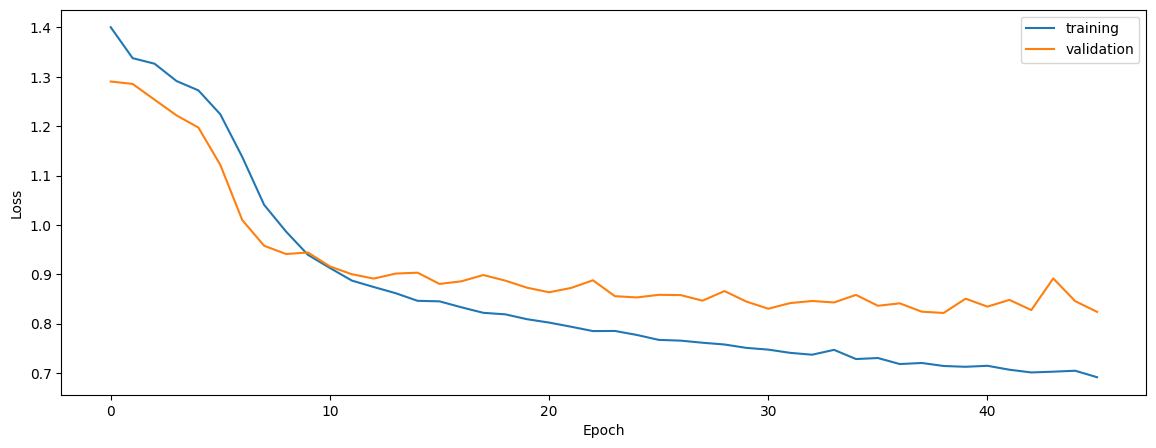

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7161947378716745
0.6926033934252386
0.7132749546873977


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7161947378716745
0.6926033934252386
0.7132749546873977


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7141117014383828
0.6848721283051582
0.7216901408450704


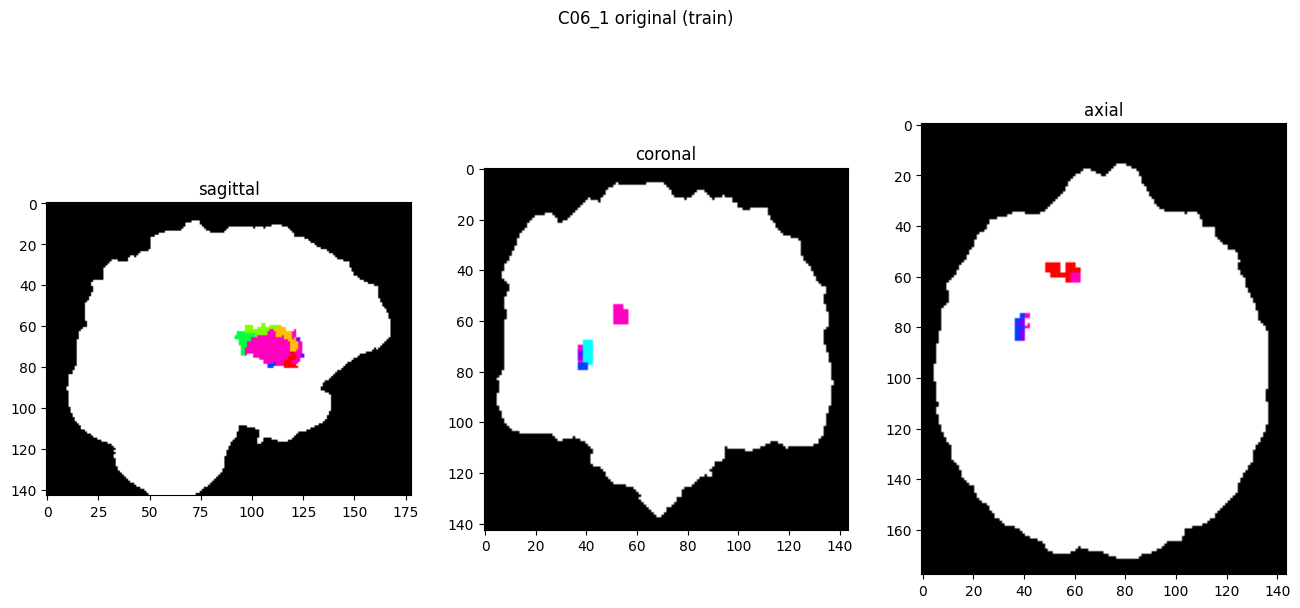

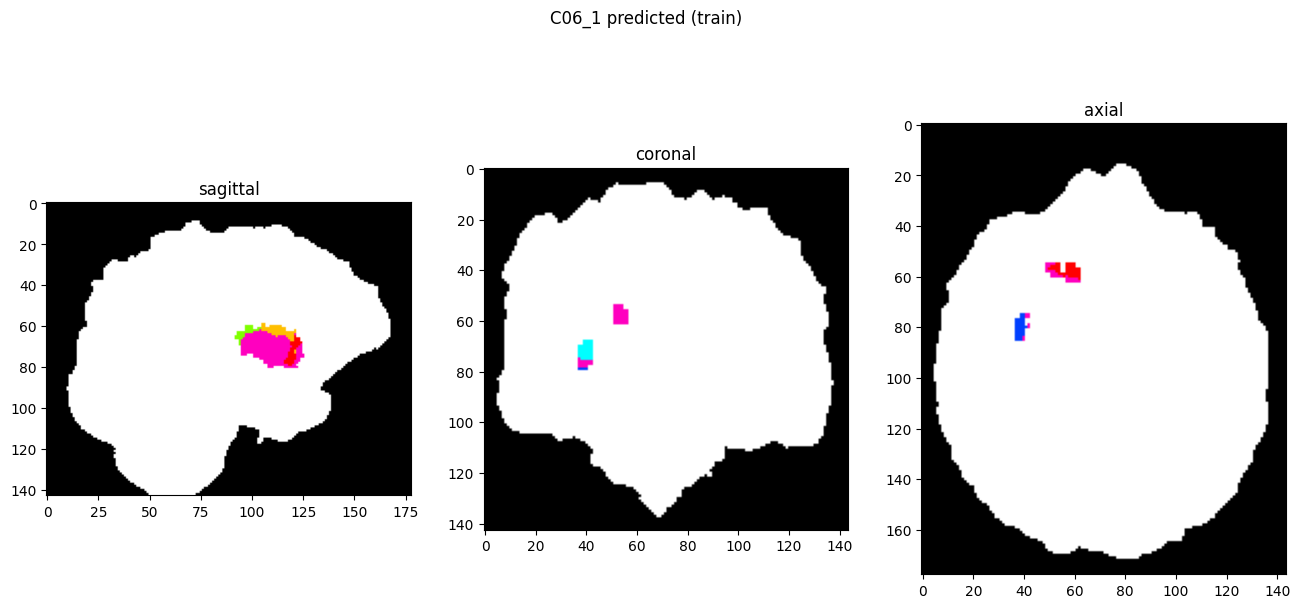

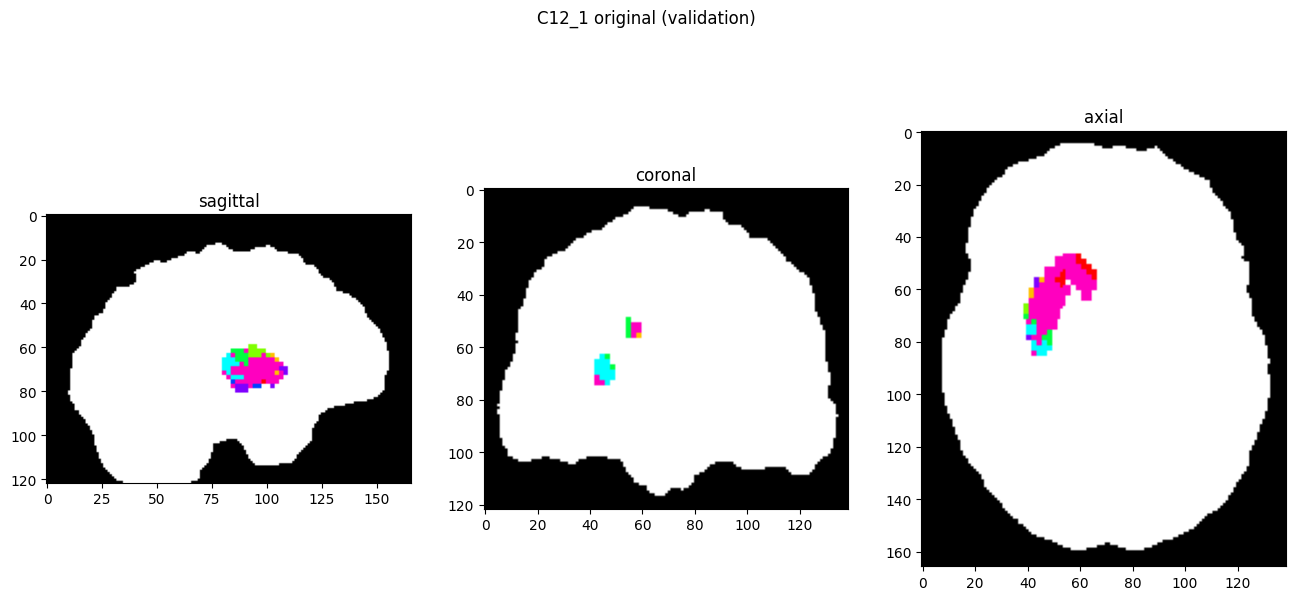

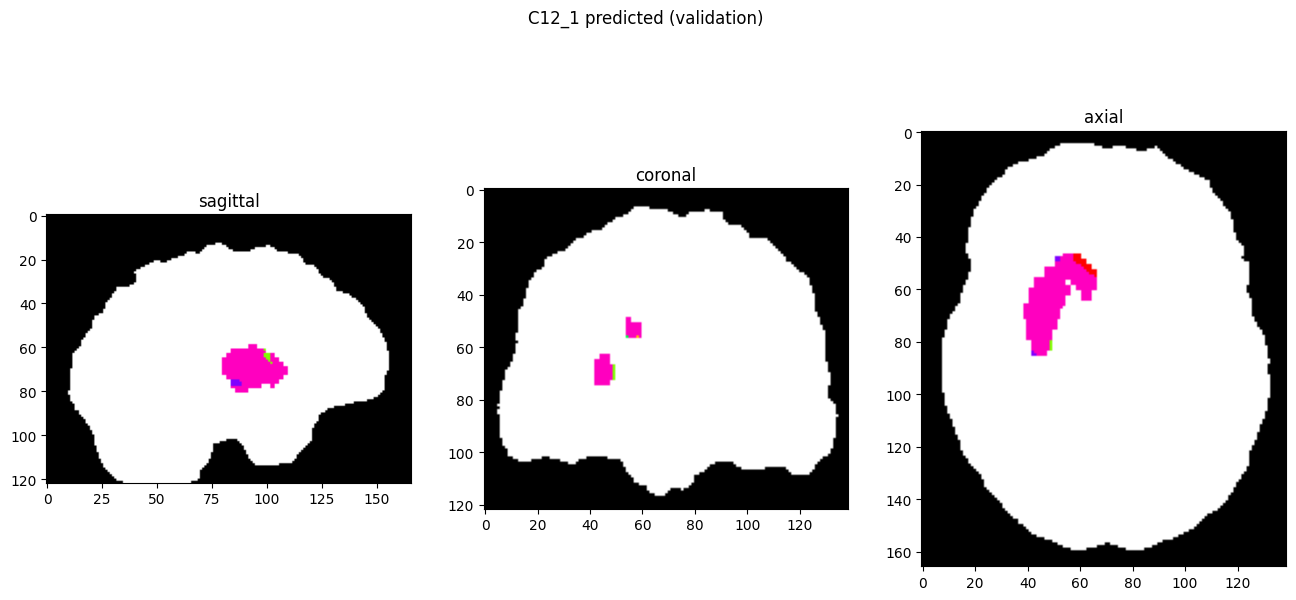

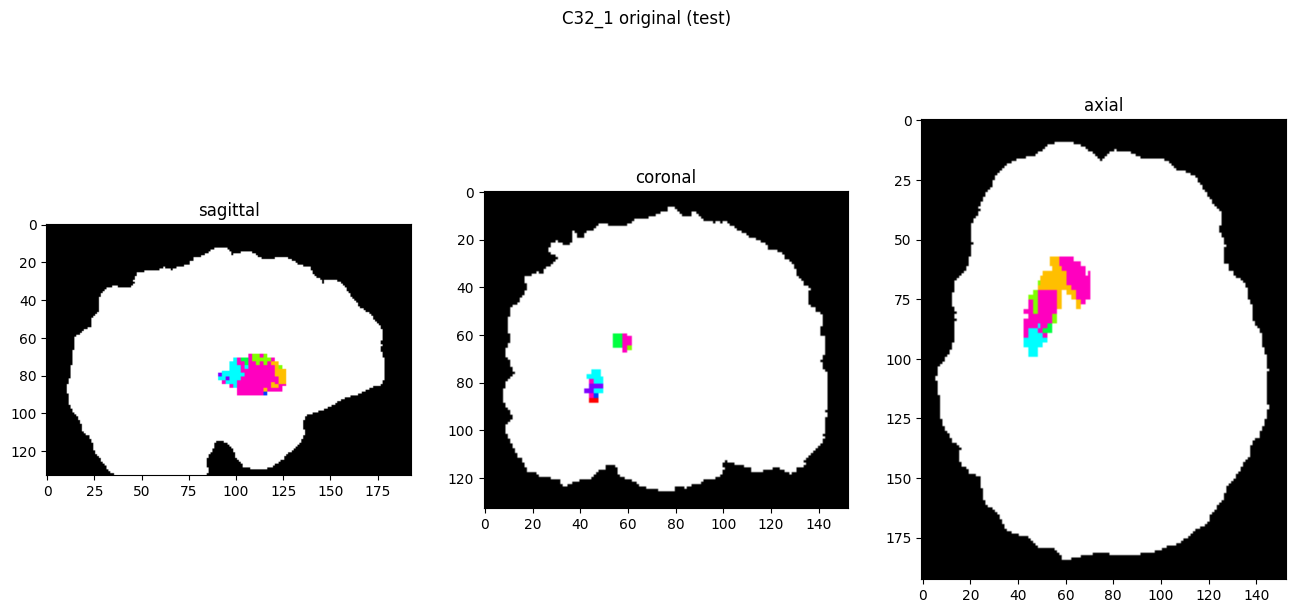

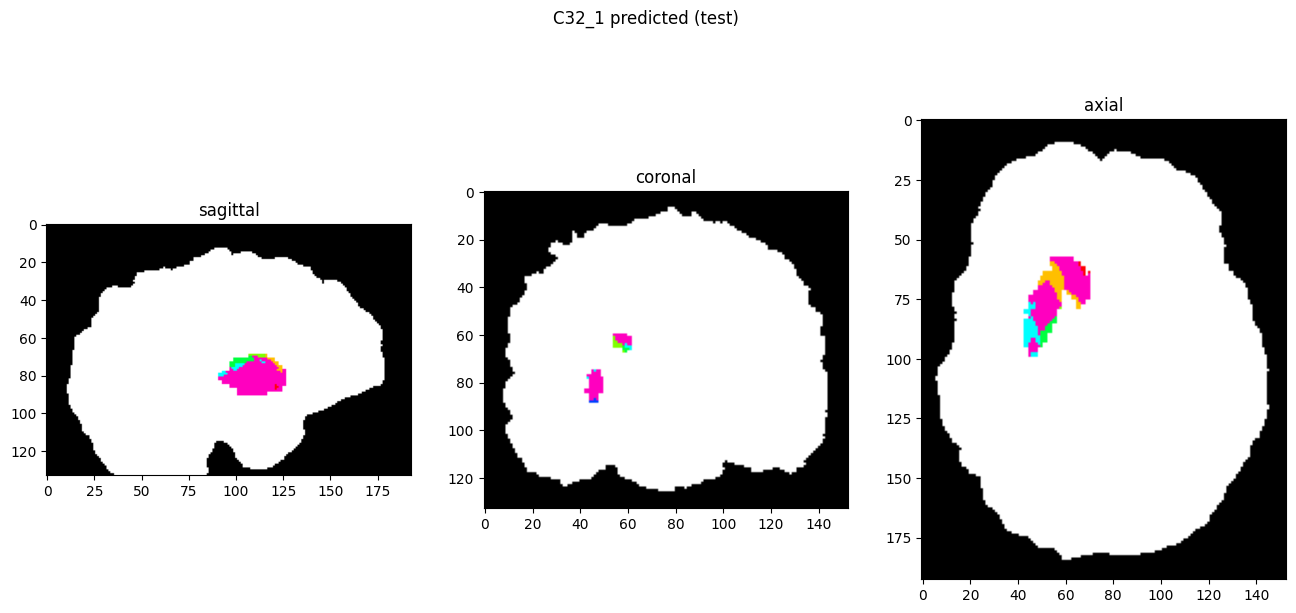

In [10]:
showResults(model, gen, threshold=0)